In [4]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
from wfsc_tests.math_module import xp, _scipy
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

import cgi_phasec_poppy as cgi
reload(cgi)

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

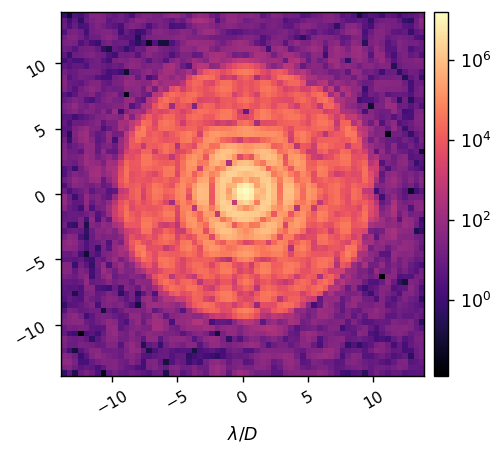

15167884.4713195

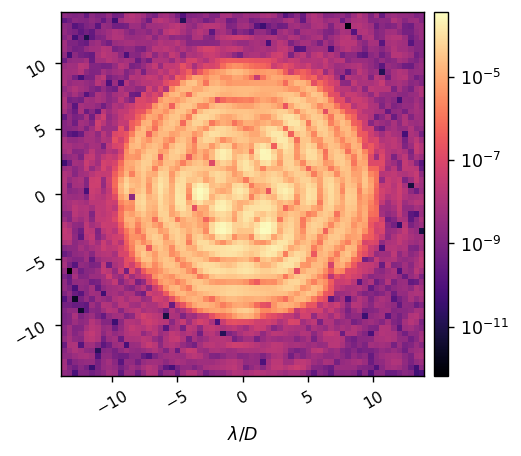

In [5]:
reload(cgi)

source_flux = 2.0208517e8 * u.ph/u.s/u.m**2 # flux of 47 UMa at 575nm with 10% bandpass

c = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=source_flux,
            exp_time=5)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = source_flux/max_ref # divide the source flux to get nominal contrast images
ref_im = c.snap()
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

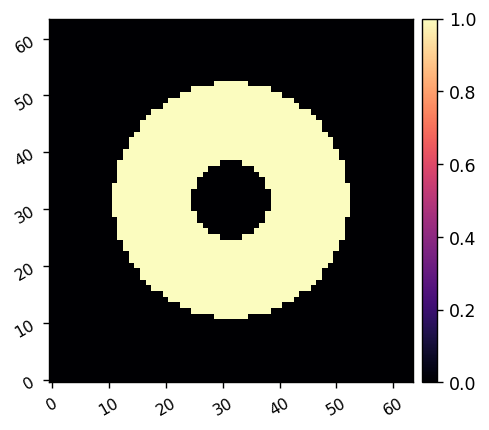

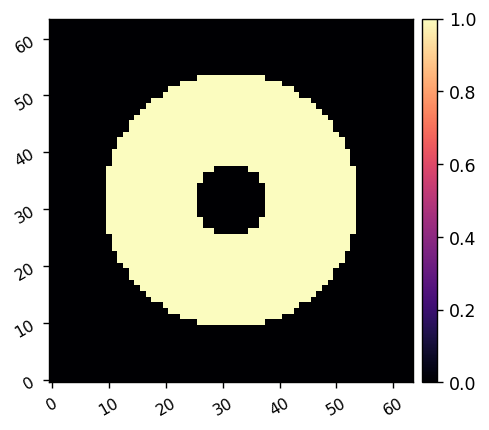

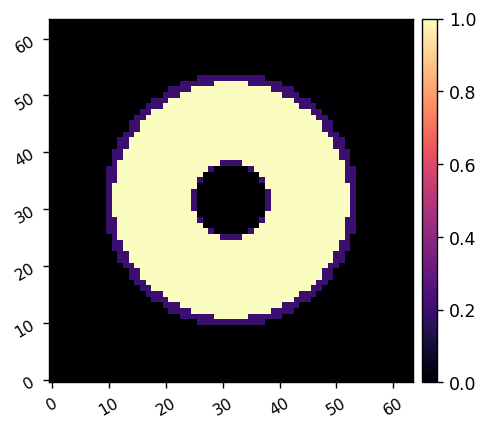

In [6]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 0,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

# wfsc.imshow2(roi1, roi2)
relative_weight = 0.2
weight_map = roi1 + relative_weight*(roi2 * ~roi1)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

probe_amp = 3e-8
calib_amp = 5e-9

# Create probe and fourier modes

(460, 2304) (230, 2)


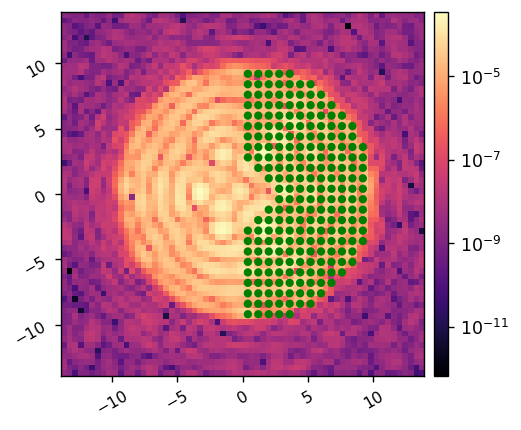

In [10]:
reload(wfsc.utils)
calib_amp = 5e-9
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.8) 
nmodes = fourier_modes.shape[0]
nf = nmodes//2
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

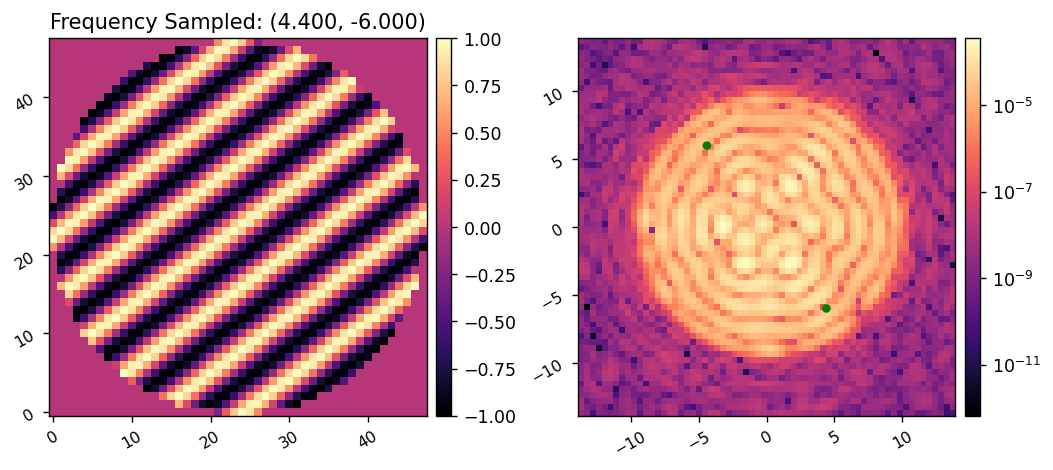

In [15]:
for i in range(fourier_modes.shape[0]//2):
    try:
        wfsc.imshow2(fourier_modes[i].reshape(Nact,Nact), ref_im, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=c.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

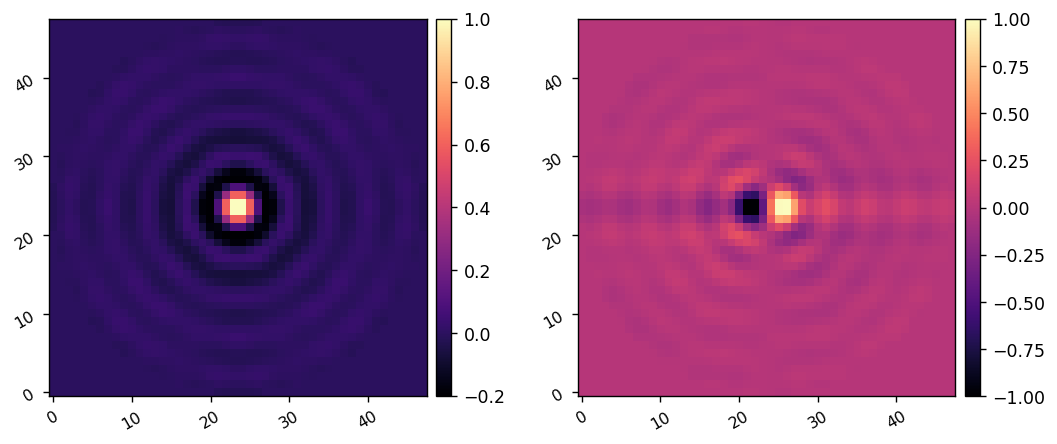

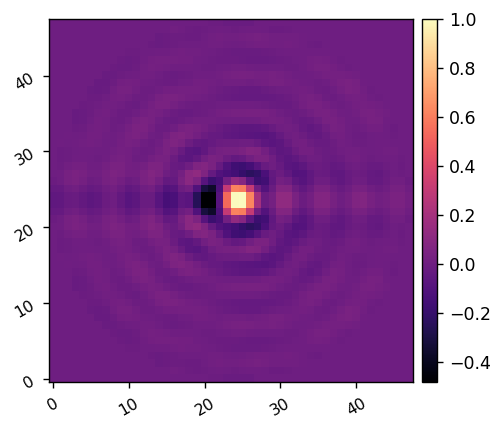

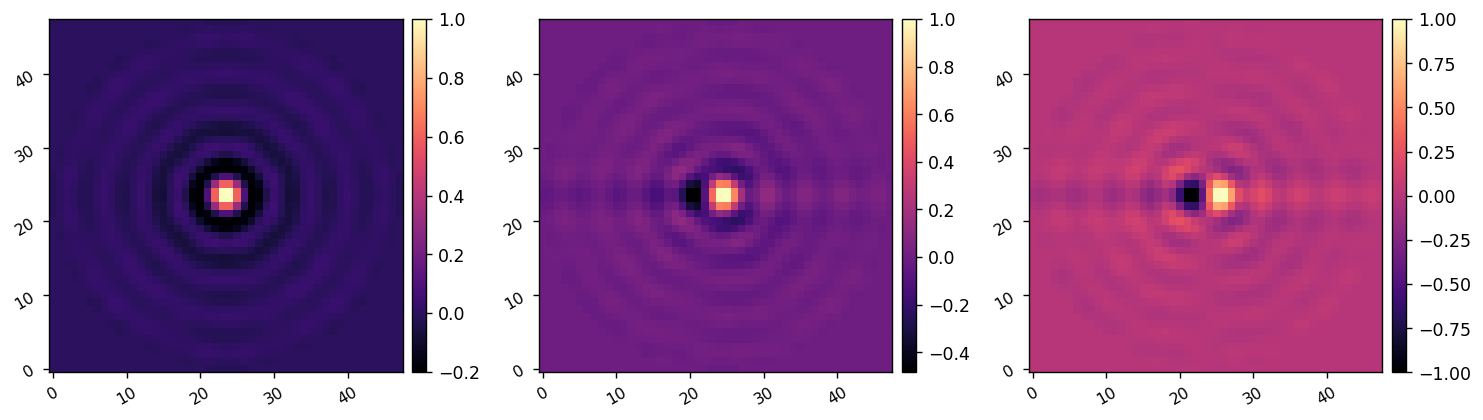

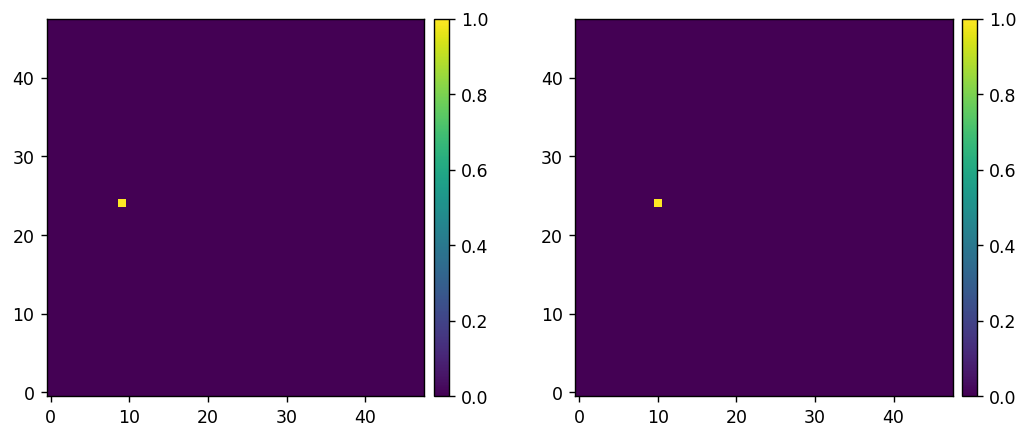

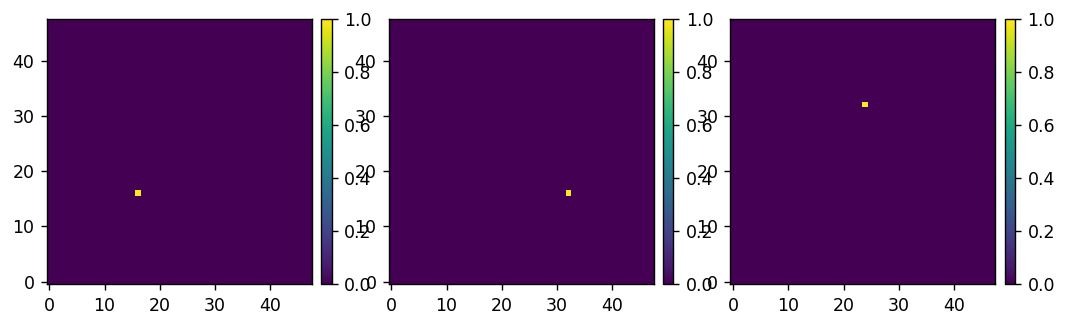

In [11]:
reload(wfsc.utils)
probe_modes_1 = wfsc.utils.create_fourier_probes(fourier_modes, plot=True)
probe = 1/np.sqrt(2) * np.sum((fourier_modes[:nf] + fourier_modes[nf:]), axis=0).reshape(Nact,Nact)
probe /= probe.max()
wfsc.imshow1(probe)

probe_modes = np.array([probe_modes_1[0], probe, probe_modes_1[1]])
wfsc.imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//5, Nact//2), (Nact//5+1, Nact//2)], 
                                                 plot=True)

probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//3, Nact//3), 
                                                               (2*Nact//3, Nact//3), 
                                                               (Nact//2, 2*Nact//3)], 
                                                 plot=True)


# probe_modes = probe_modes_1 + probe_modes_2

# wfsc.imshow2(probe_modes[0], probe_modes[1])

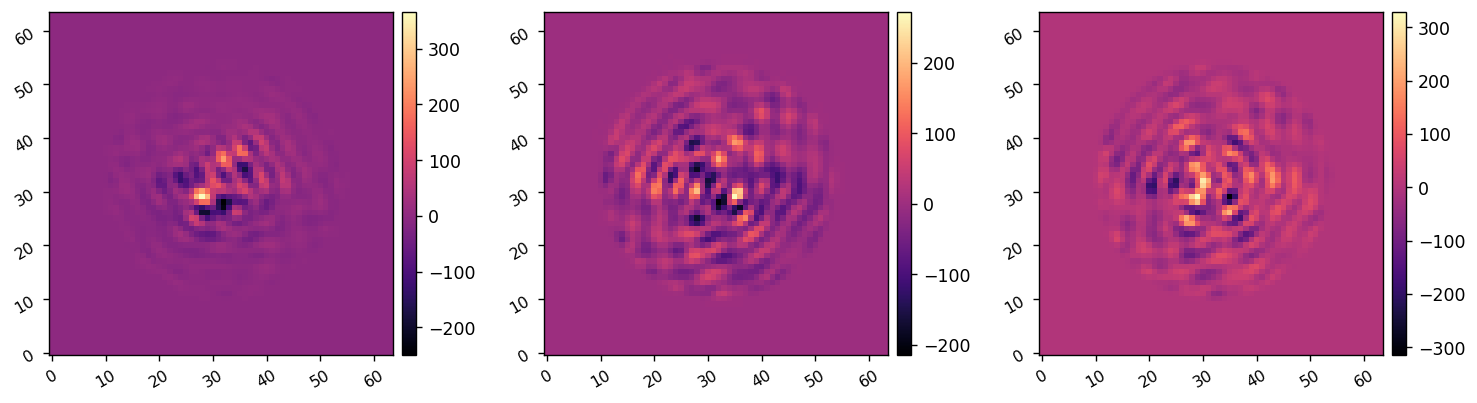

In [13]:
reload(wfsc.iefc)

probe_amp = 5e-8
calib_amp = 5e-9

# c.texp = 1

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(3, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [14]:
reload(wfsc.iefc_2dm)
response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 460 in 15.935s
	Calibrated mode 2 / 460 in 31.904s
	Calibrated mode 3 / 460 in 47.913s
	Calibrated mode 4 / 460 in 63.958s
	Calibrated mode 5 / 460 in 79.987s


KeyboardInterrupt: 

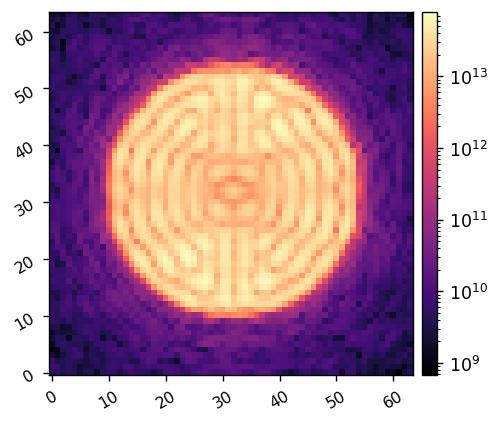

In [36]:
response_sum = xp.sum(abs(response_cube), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)

In [37]:
import misc_funs as misc

misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_2dm_response_matrix_20230518.fits', 
               wfsc.utils.ensure_np_array(response_matrix))
misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_2dm_response_cube_20230518.fits', 
               wfsc.utils.ensure_np_array(response_cube))

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_2dm_response_matrix_20230518.fits
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_2dm_response_cube_20230518.fits


# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 10


(920,)

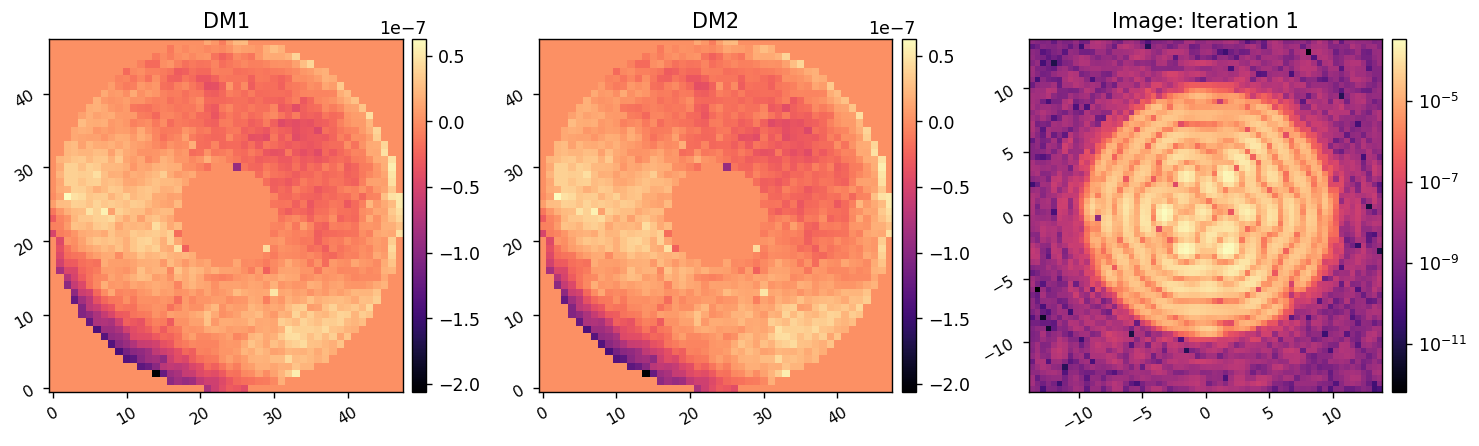

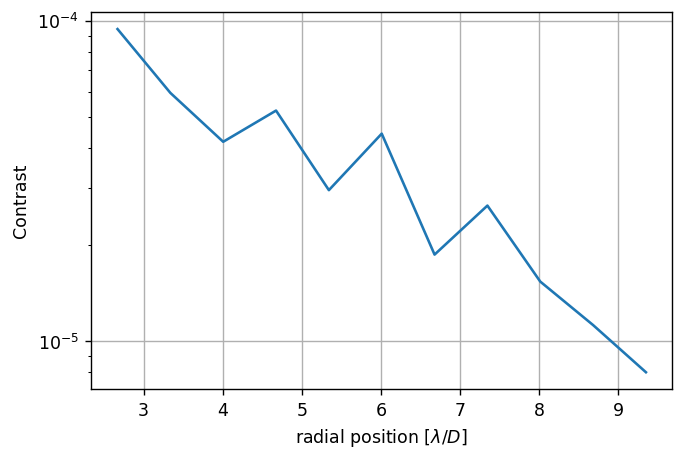

	Closed-loop iteration 2 / 10


(920,)

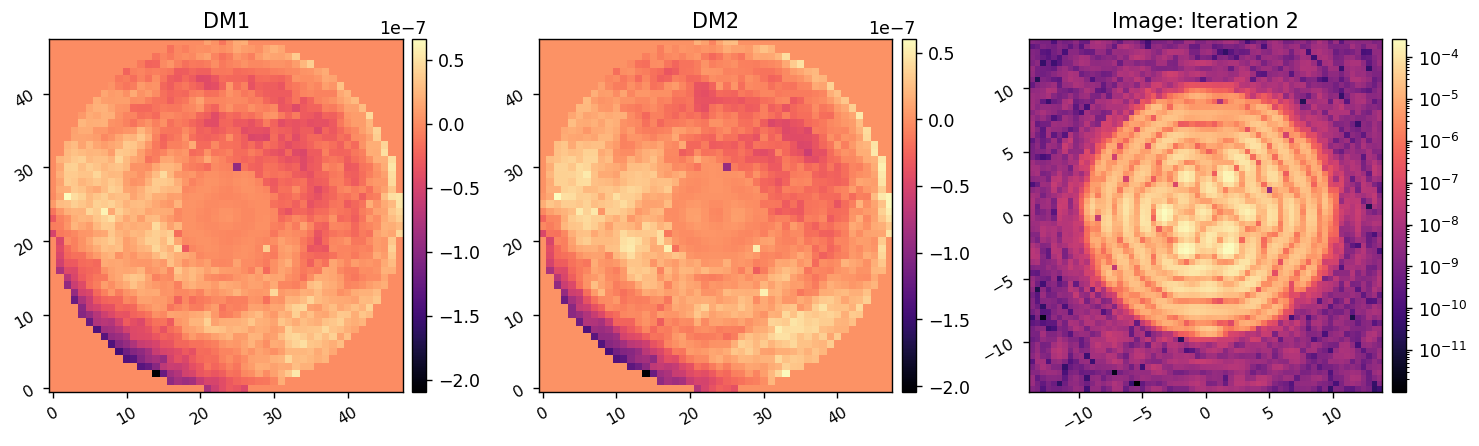

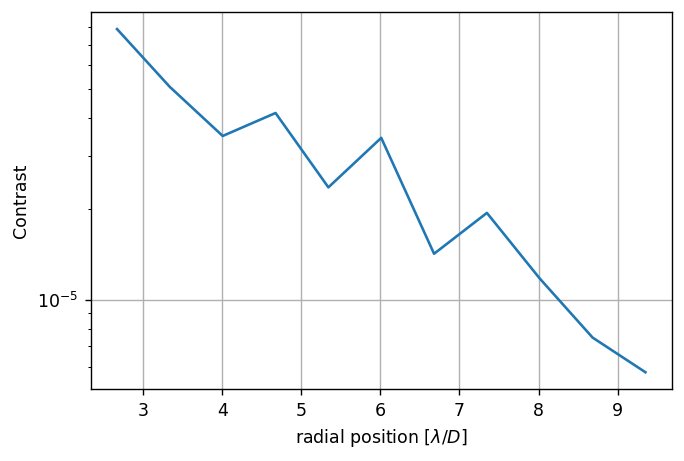

	Closed-loop iteration 3 / 10


(920,)

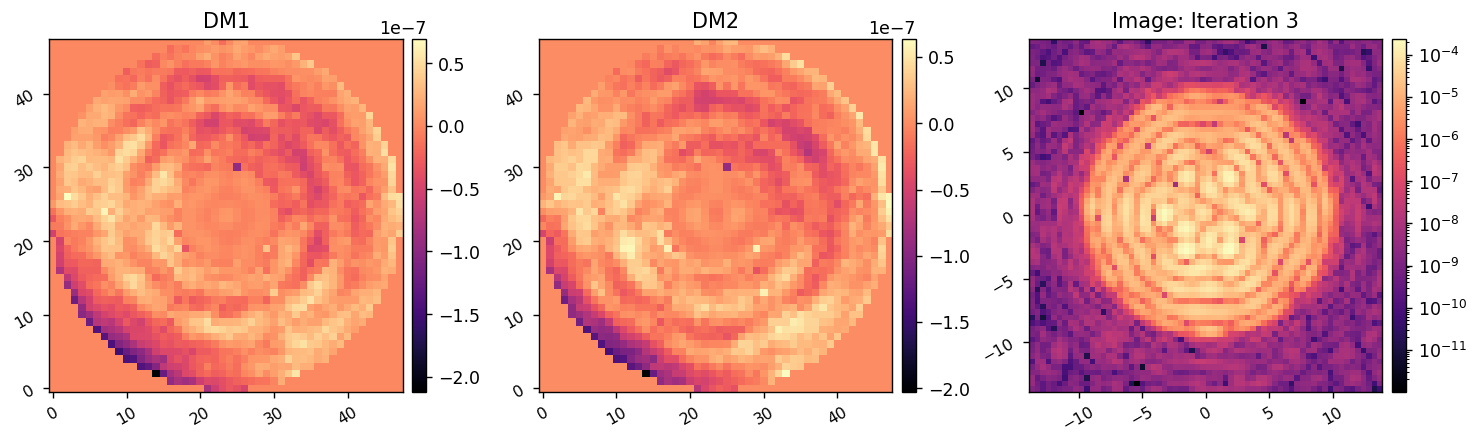

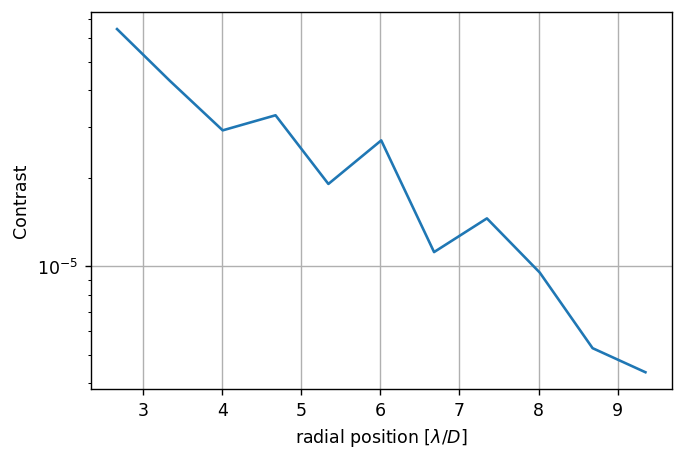

	Closed-loop iteration 4 / 10


(920,)

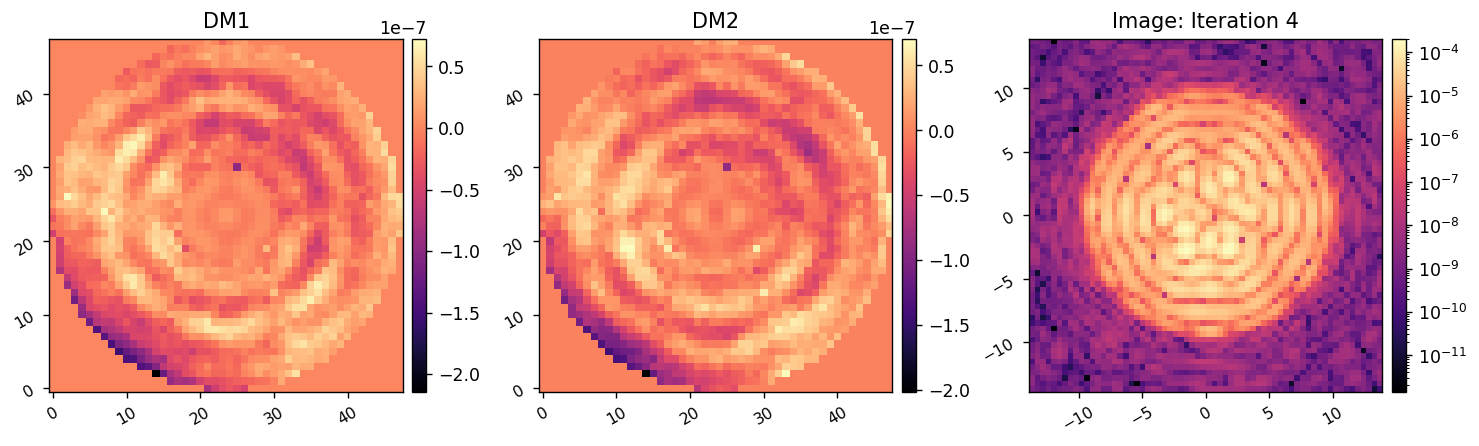

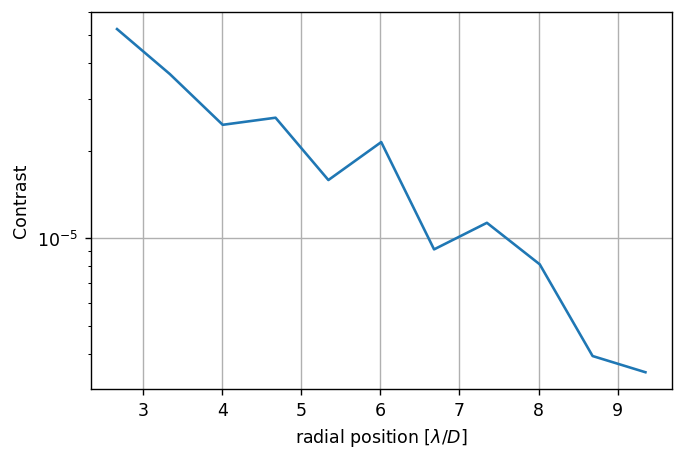

	Closed-loop iteration 5 / 10


(920,)

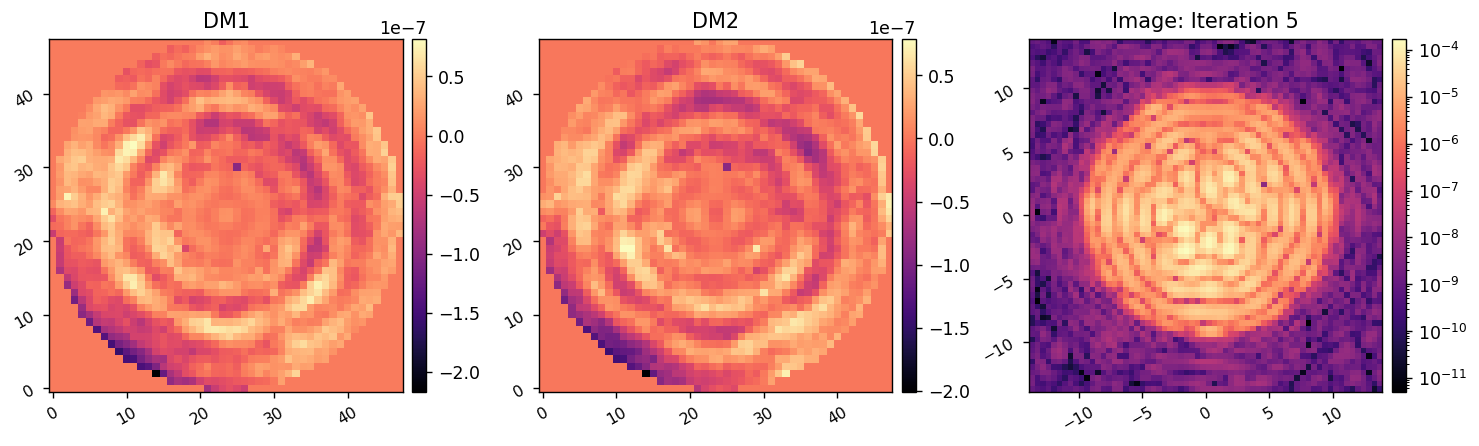

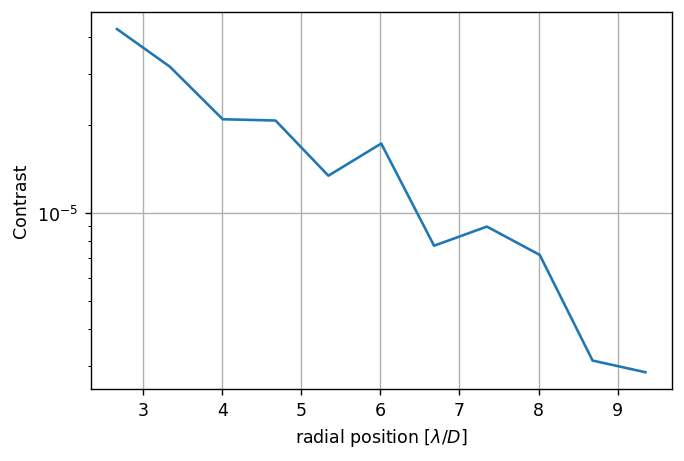

	Closed-loop iteration 6 / 10


(920,)

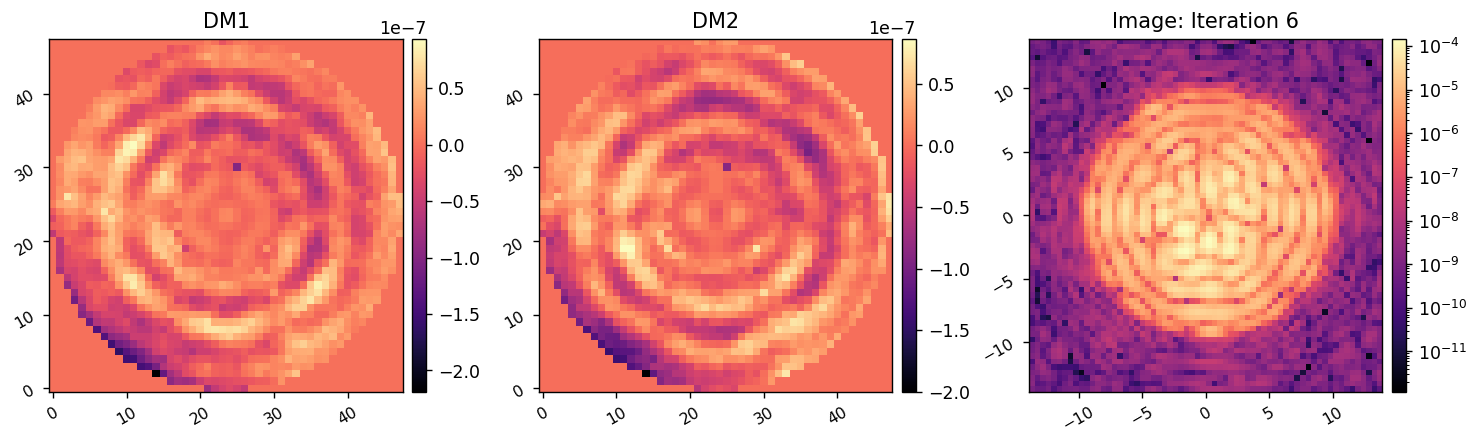

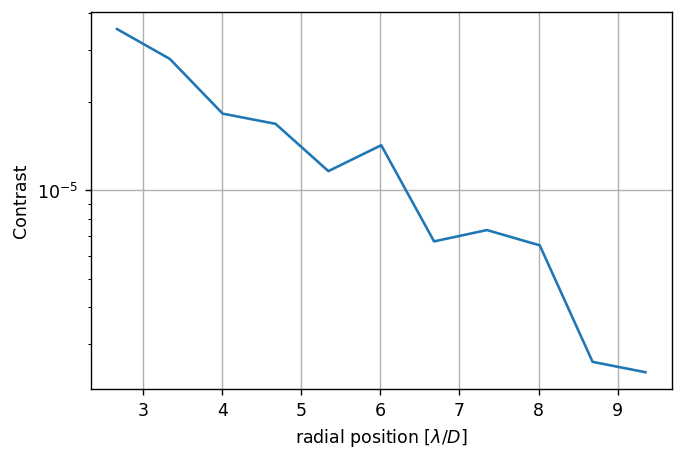

	Closed-loop iteration 7 / 10


(920,)

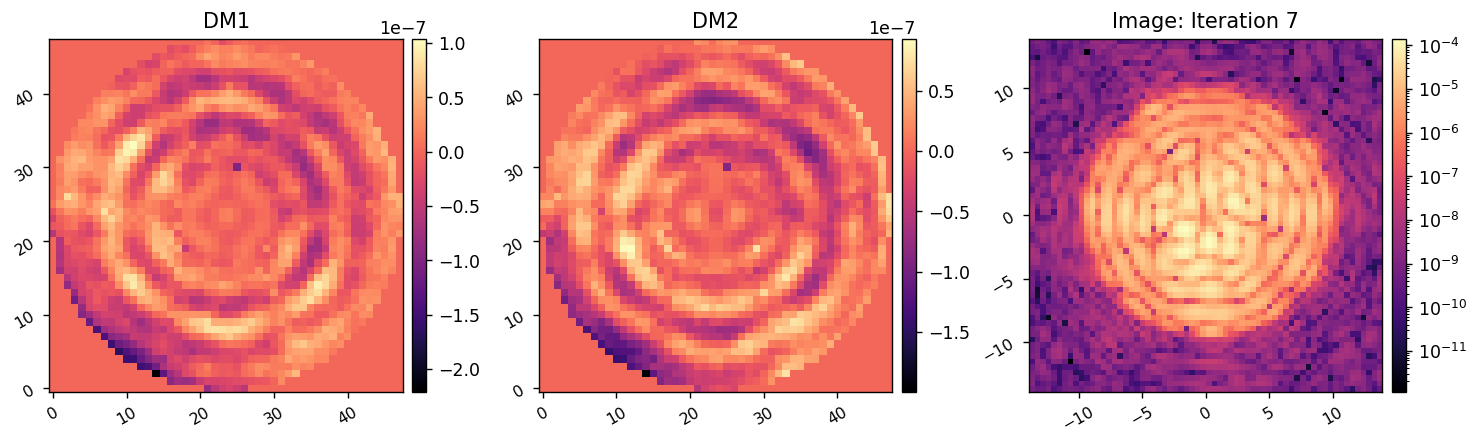

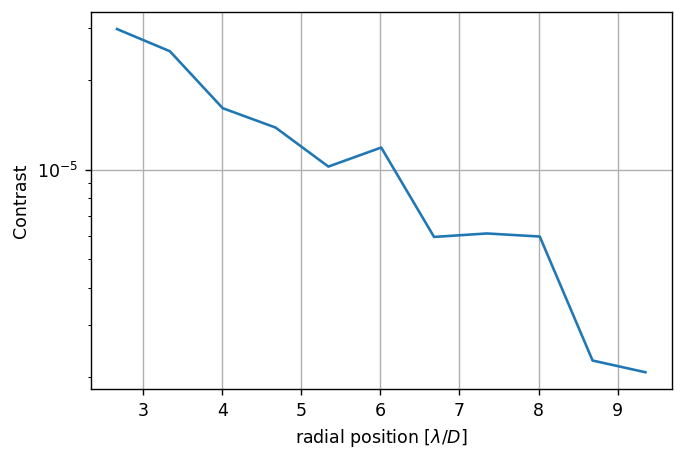

	Closed-loop iteration 8 / 10


(920,)

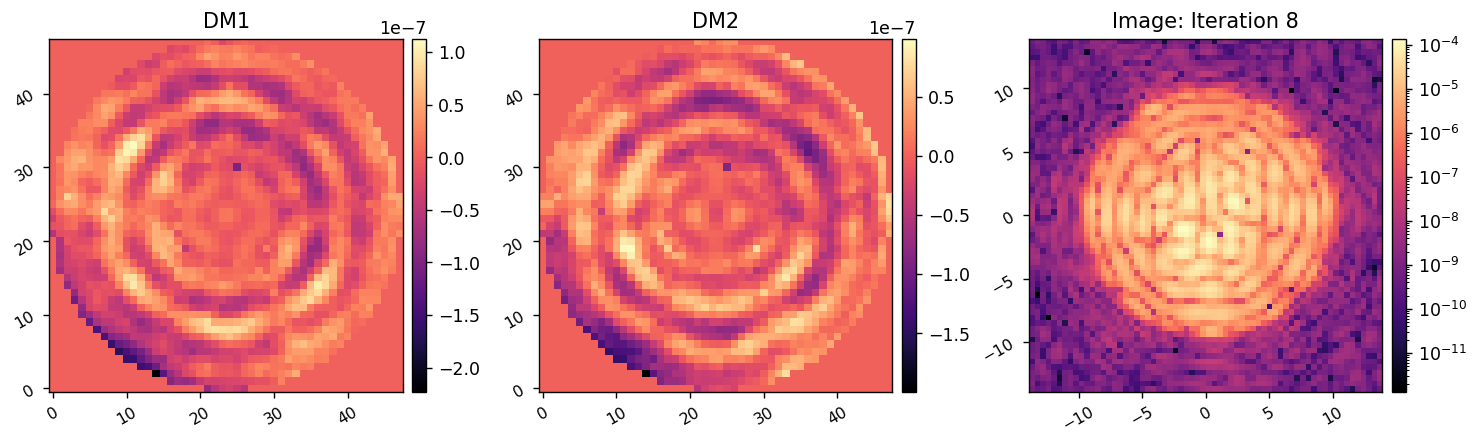

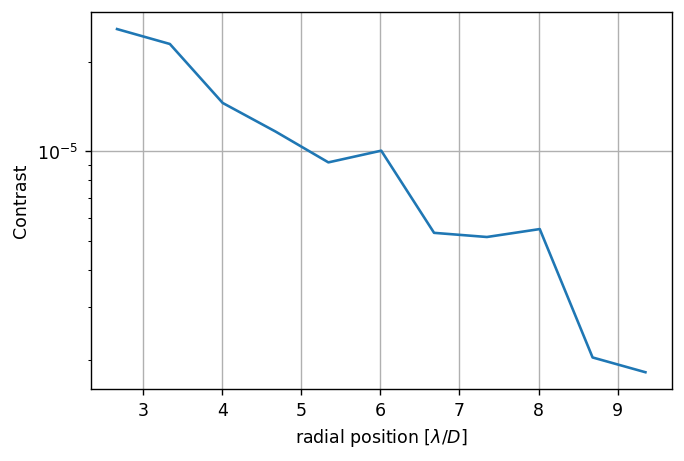

	Closed-loop iteration 9 / 10


(920,)

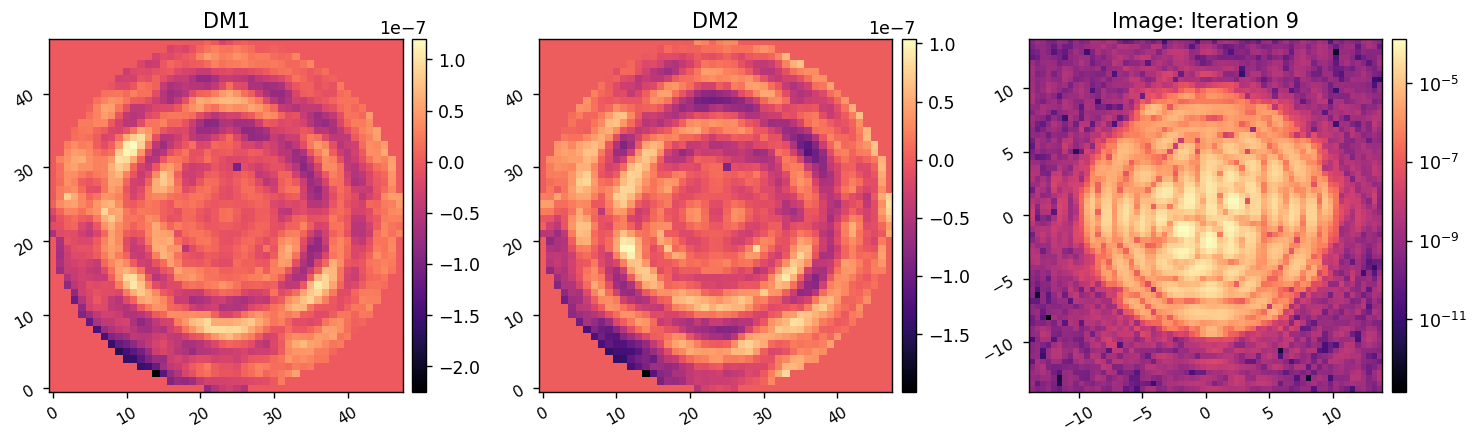

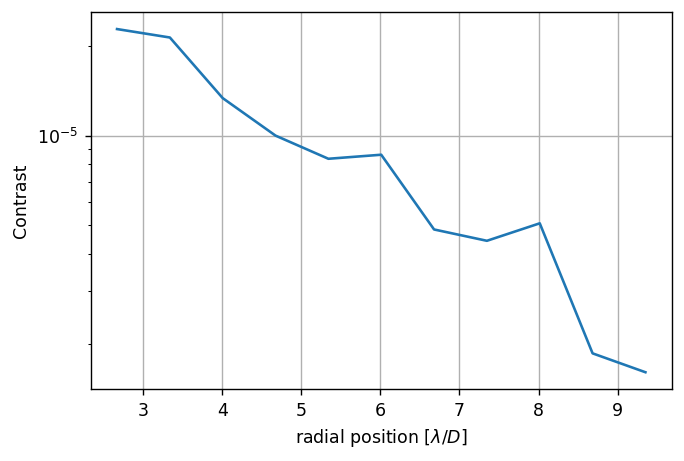

	Closed-loop iteration 10 / 10


(920,)

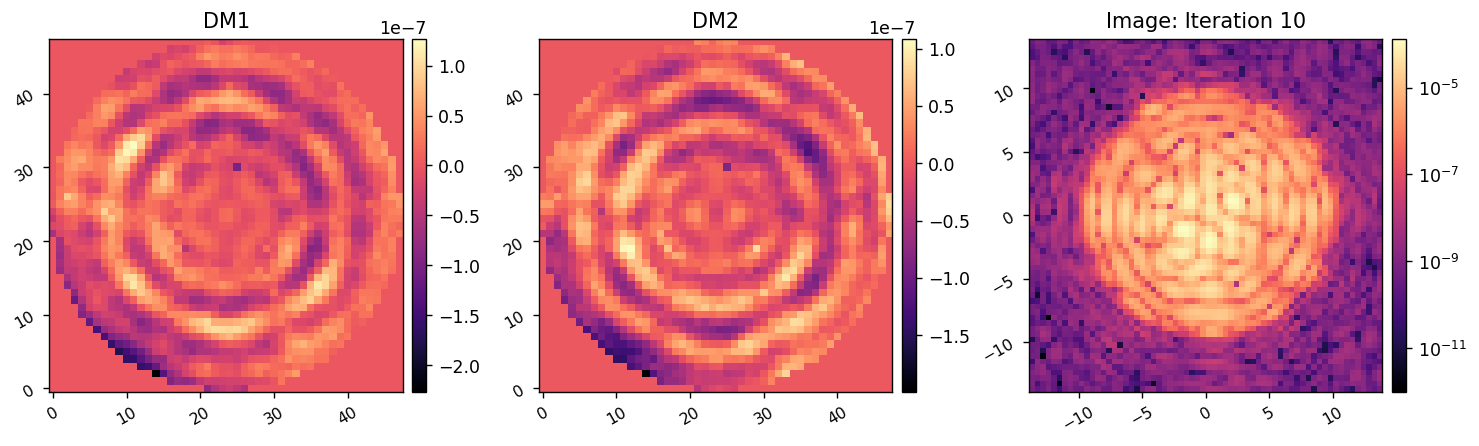

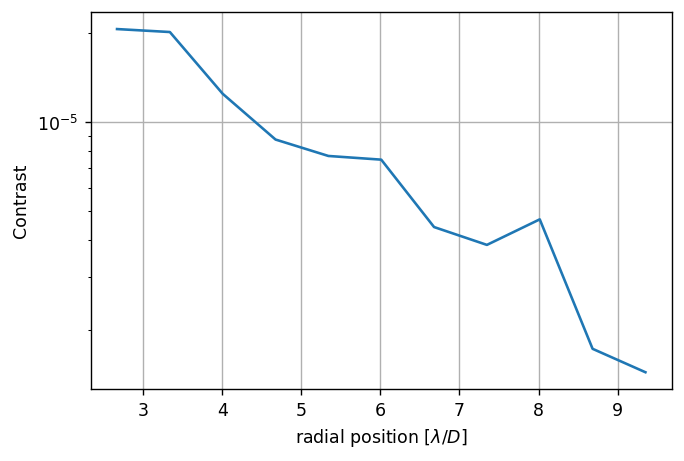

I-EFC loop completed in 24.406s.
Running I-EFC...
	Closed-loop iteration 1 / 20


(920,)

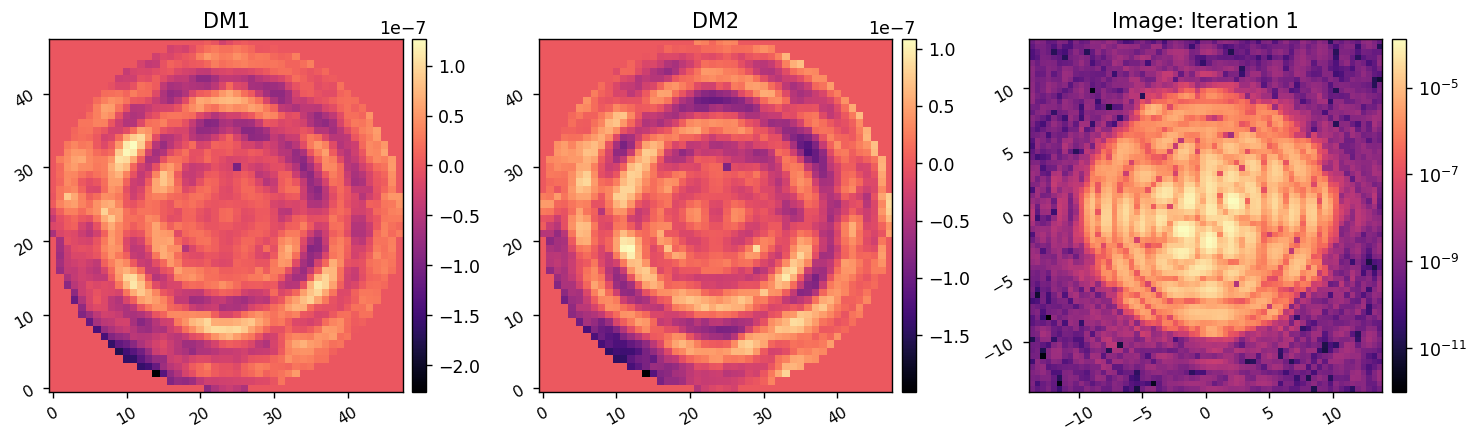

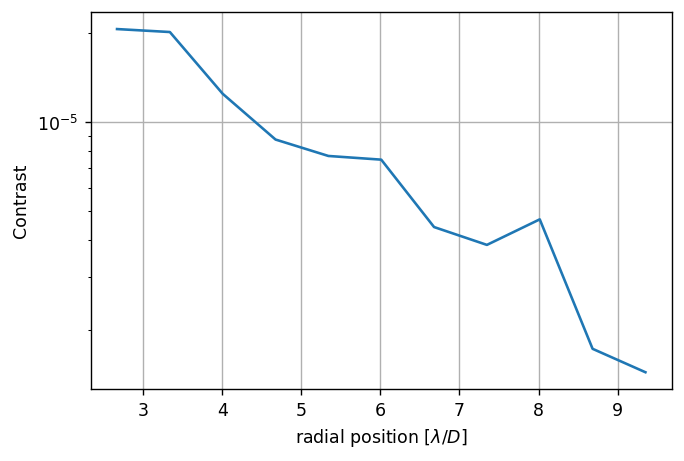

	Closed-loop iteration 2 / 20


(920,)

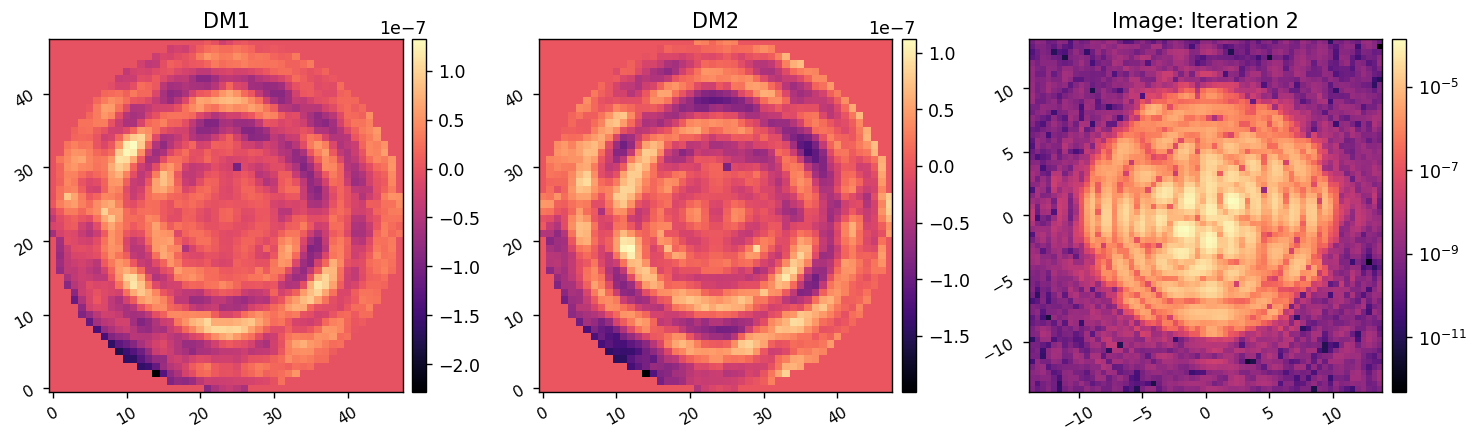

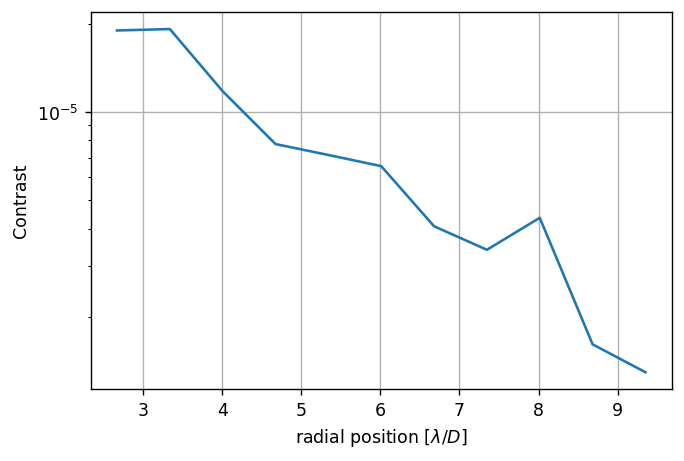

	Closed-loop iteration 3 / 20


(920,)

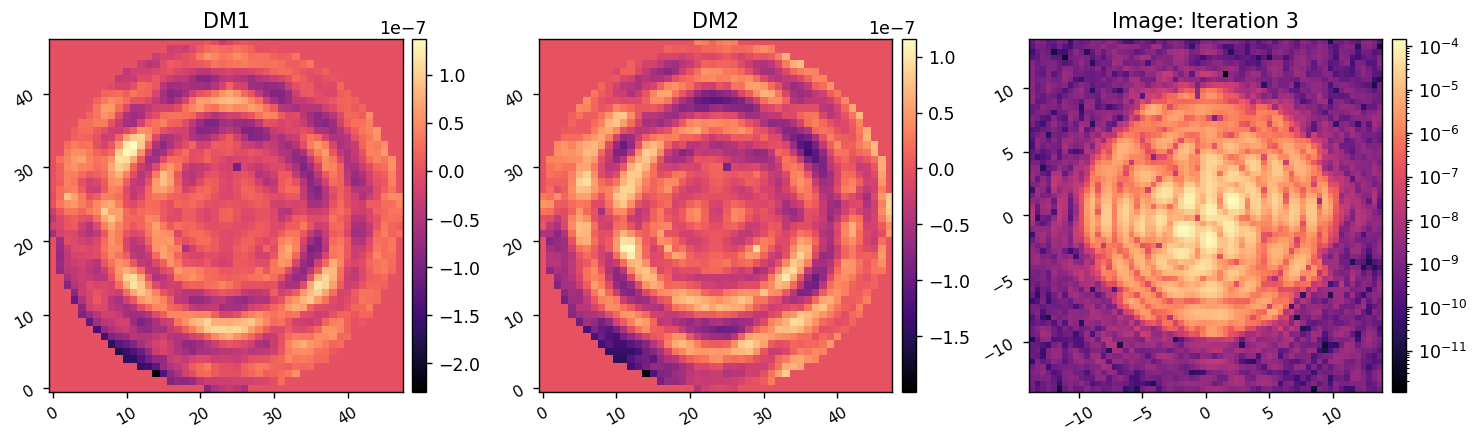

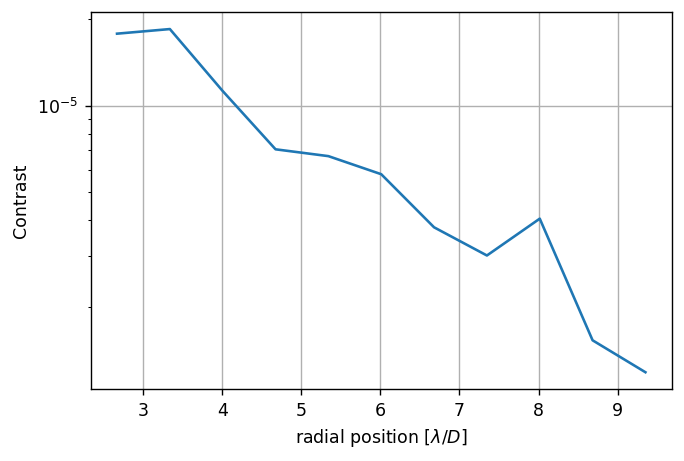

	Closed-loop iteration 4 / 20


(920,)

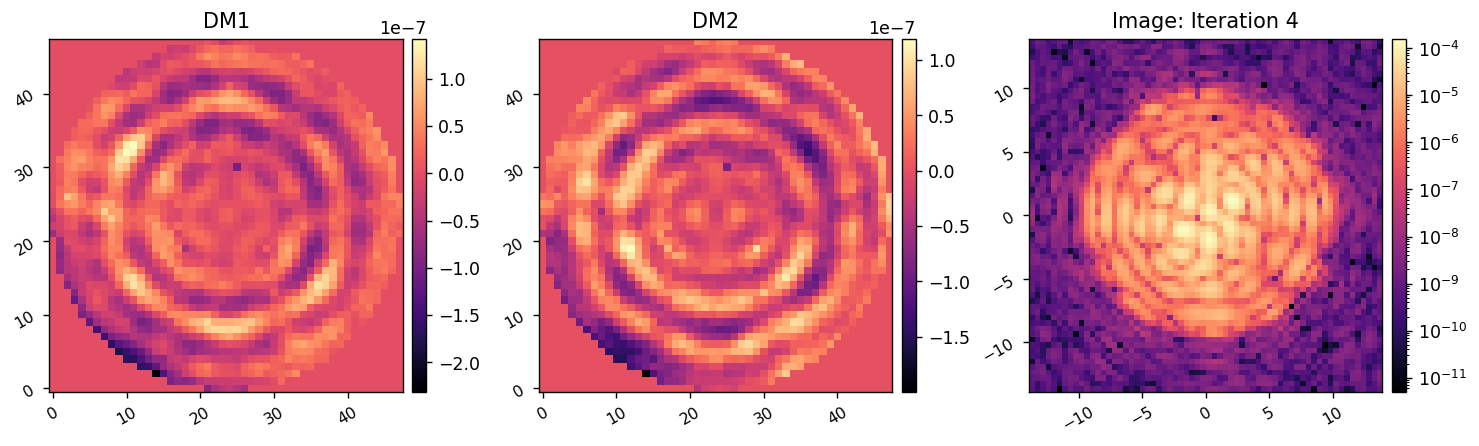

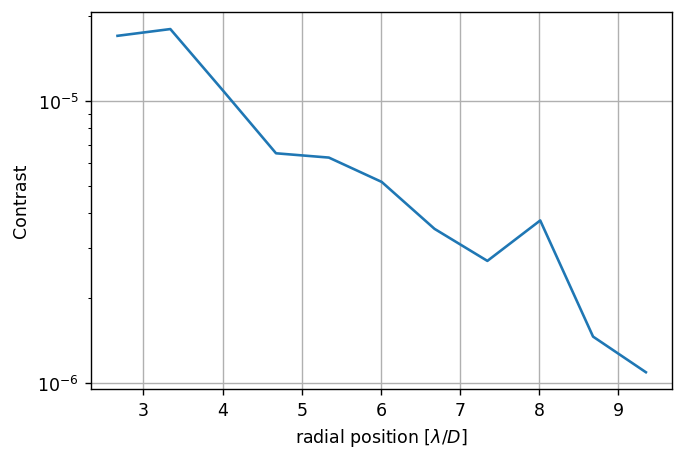

	Closed-loop iteration 5 / 20


(920,)

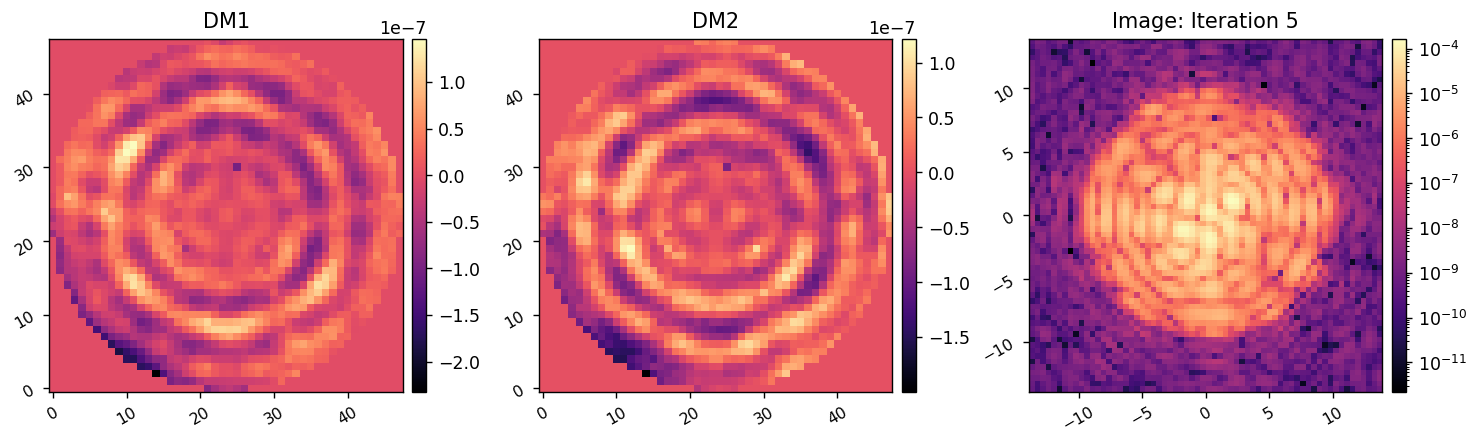

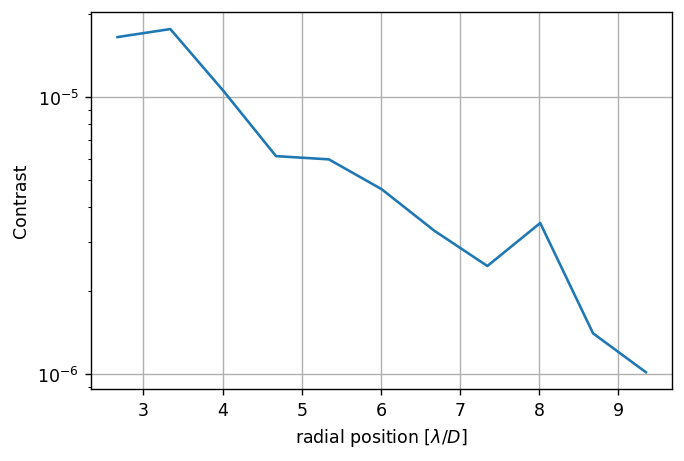

	Closed-loop iteration 6 / 20


(920,)

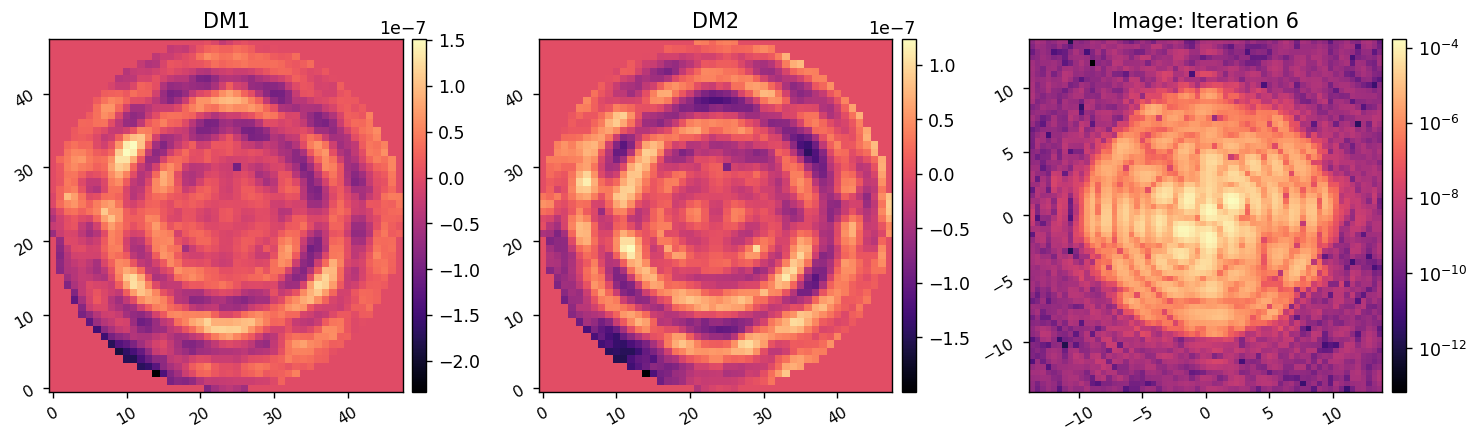

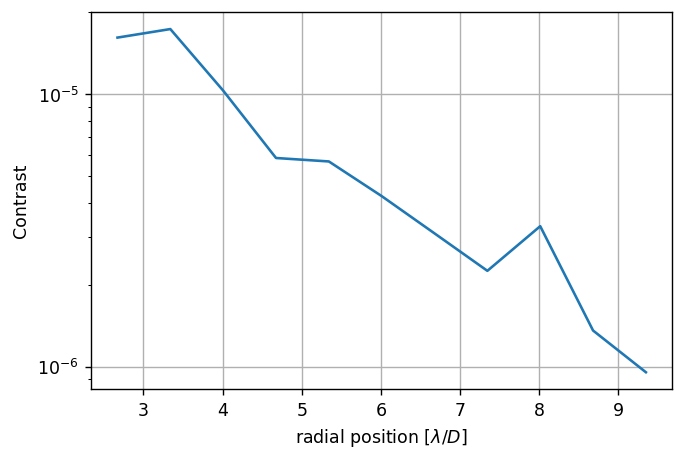

	Closed-loop iteration 7 / 20


(920,)

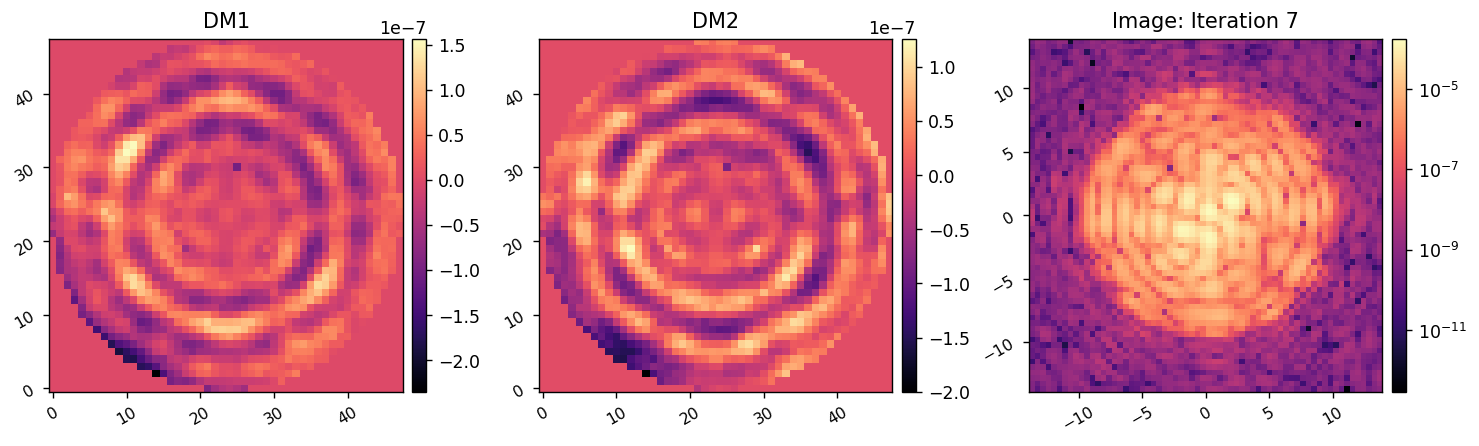

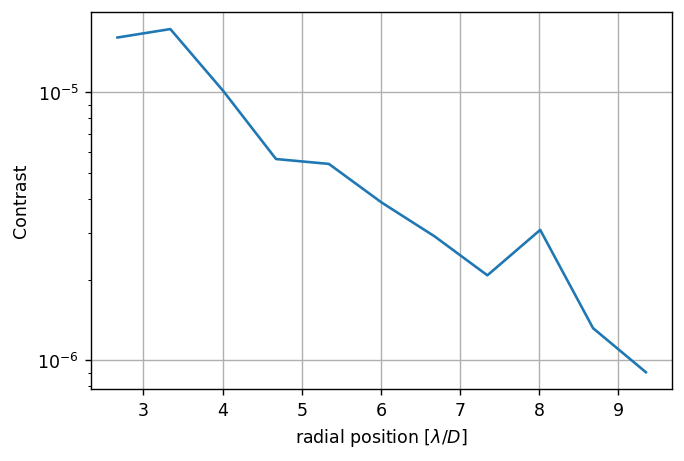

	Closed-loop iteration 8 / 20


(920,)

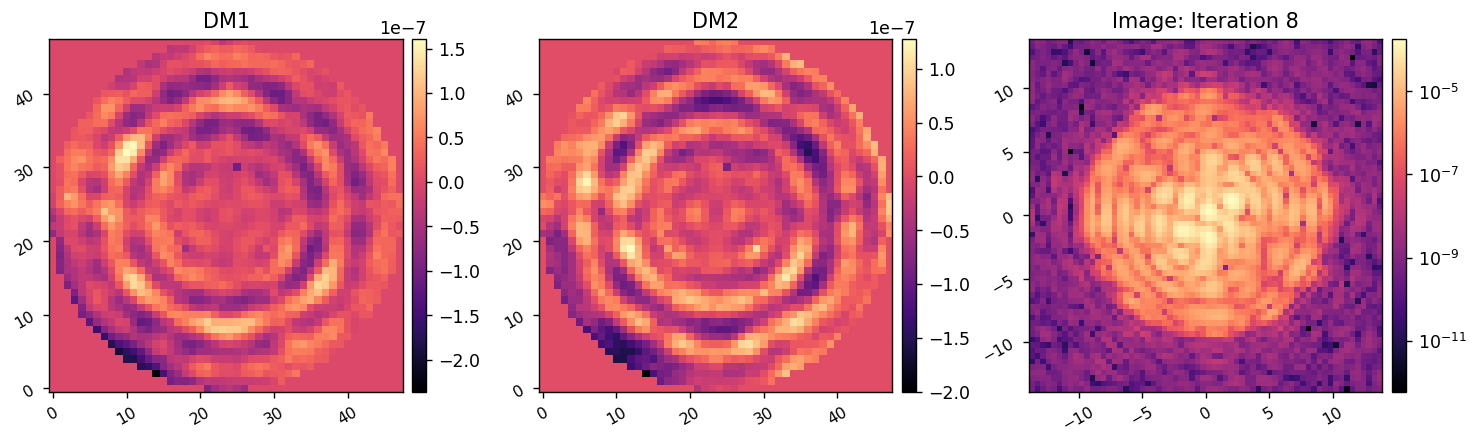

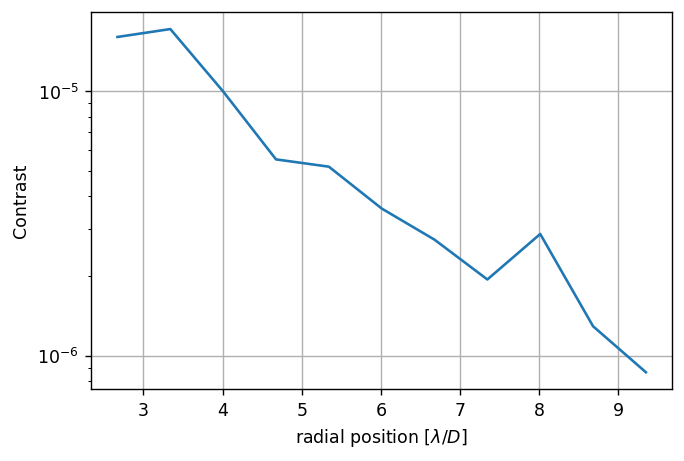

	Closed-loop iteration 9 / 20


(920,)

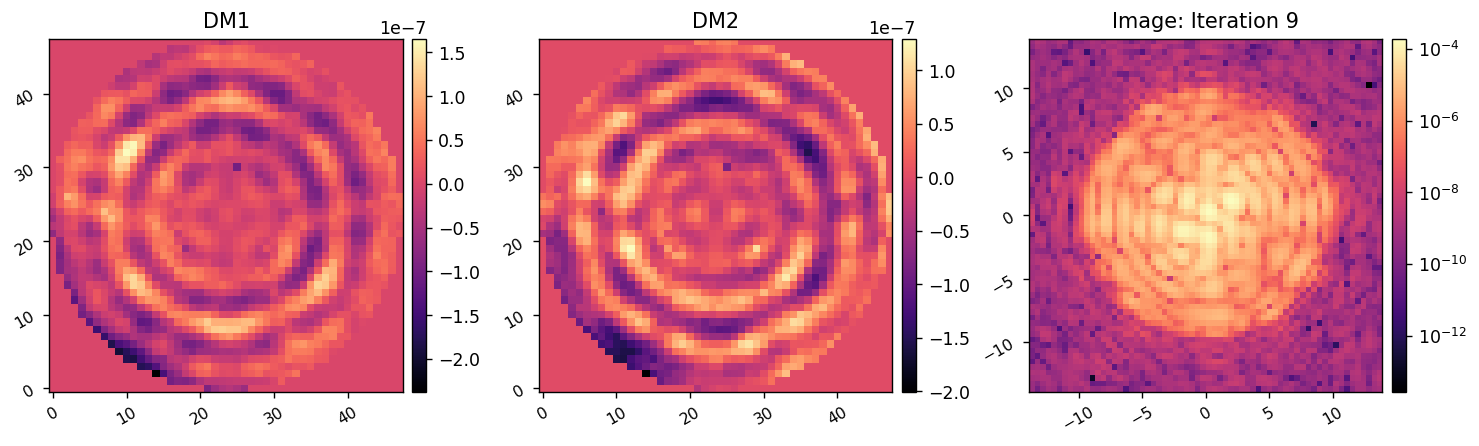

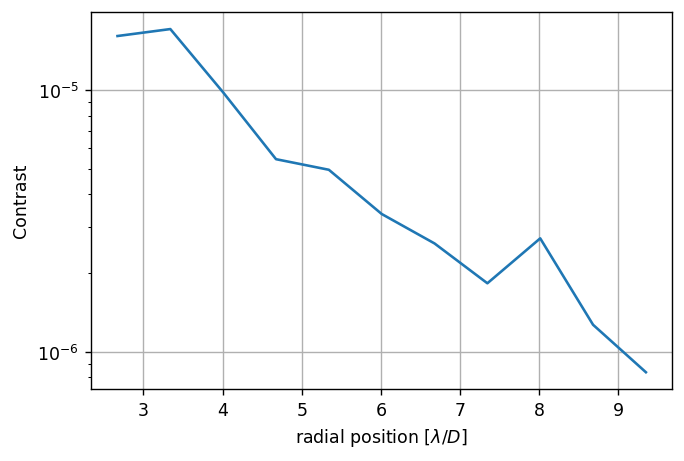

	Closed-loop iteration 10 / 20


(920,)

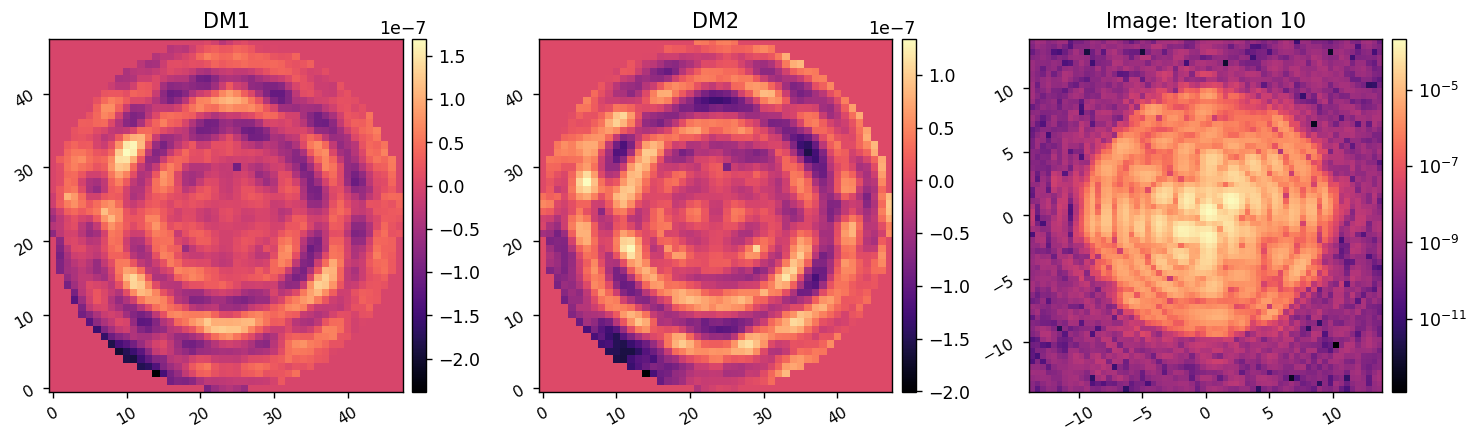

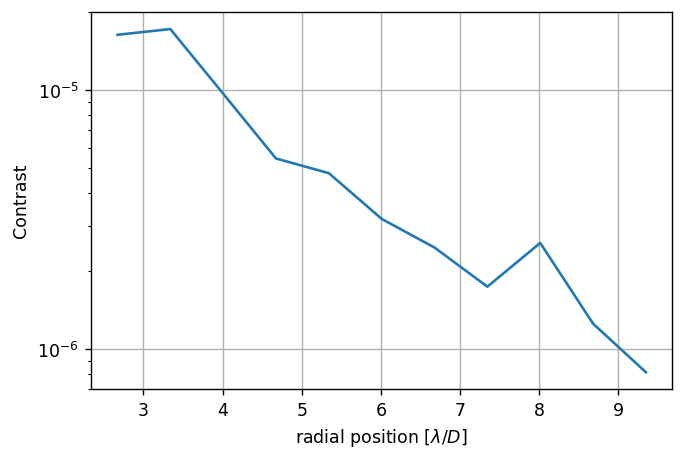

	Closed-loop iteration 11 / 20


(920,)

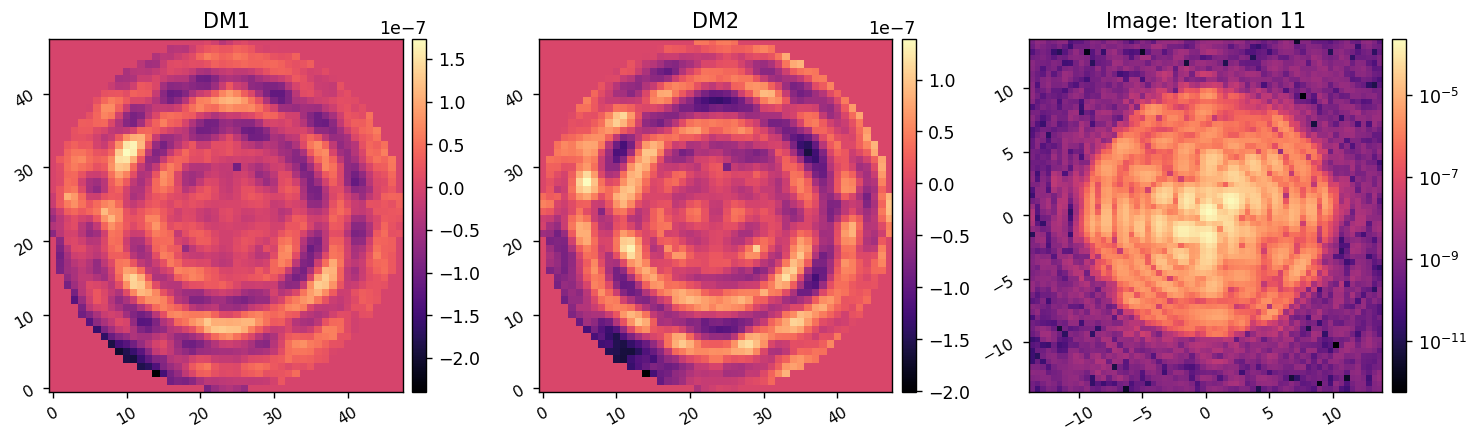

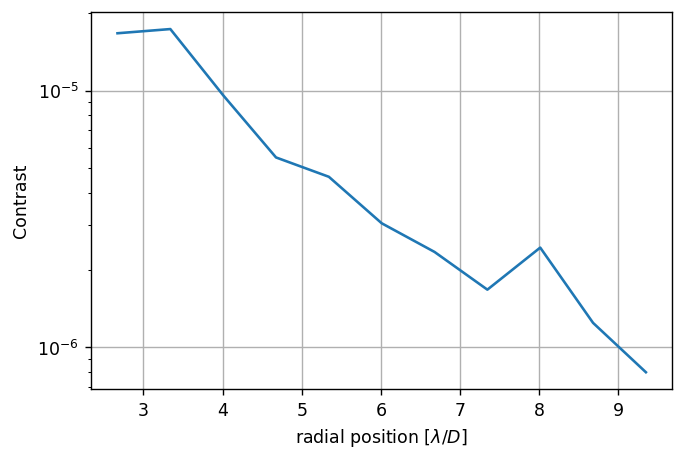

	Closed-loop iteration 12 / 20


(920,)

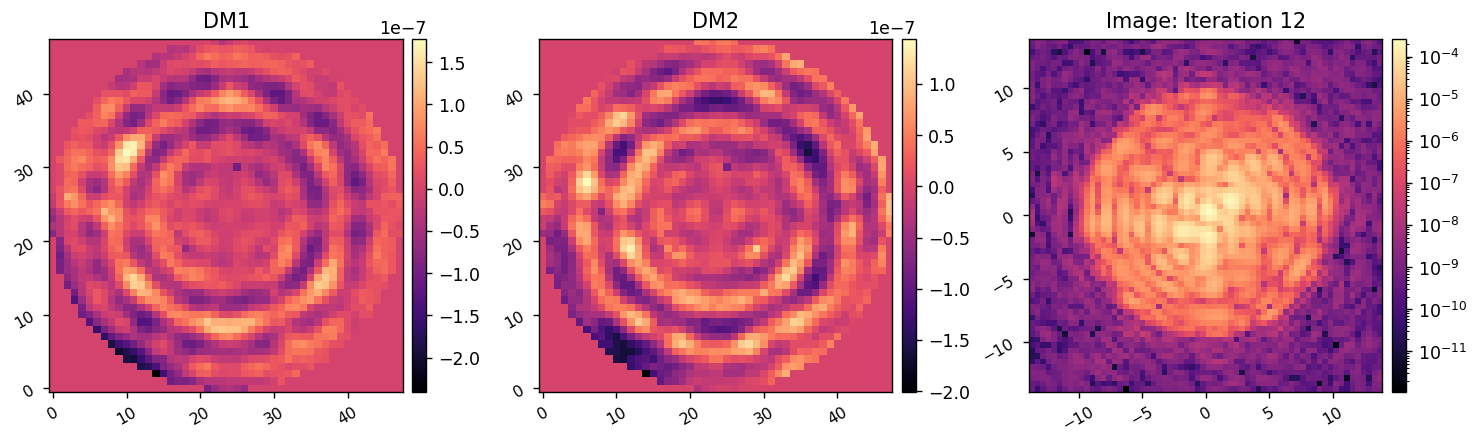

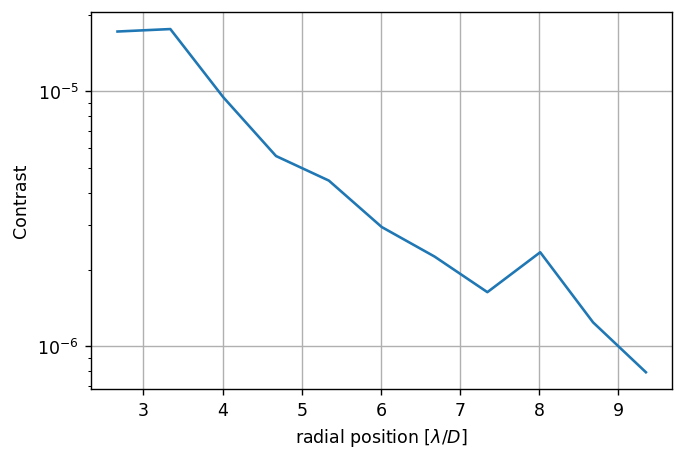

	Closed-loop iteration 13 / 20


(920,)

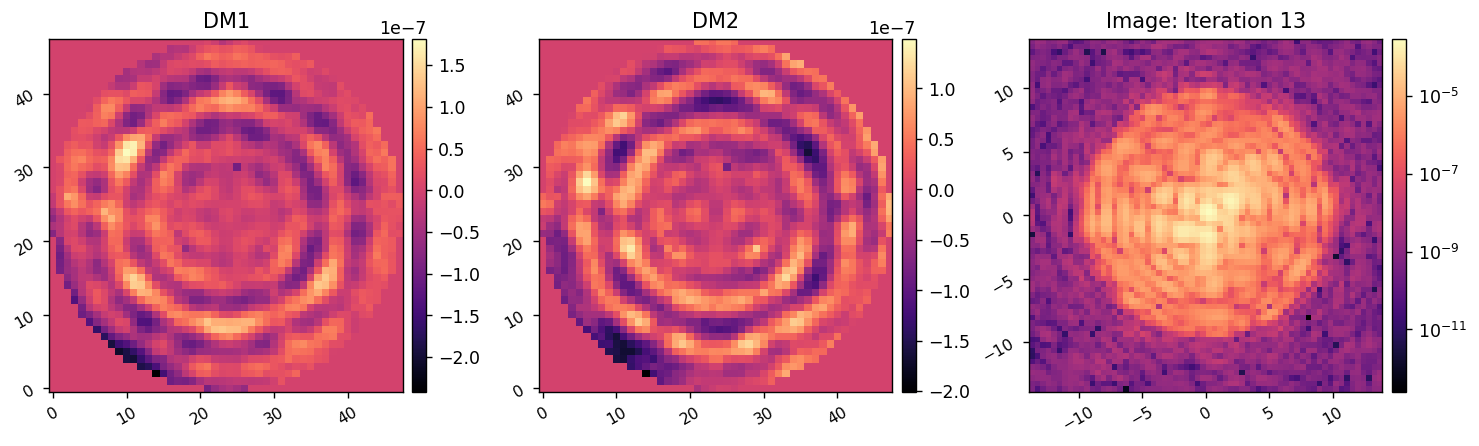

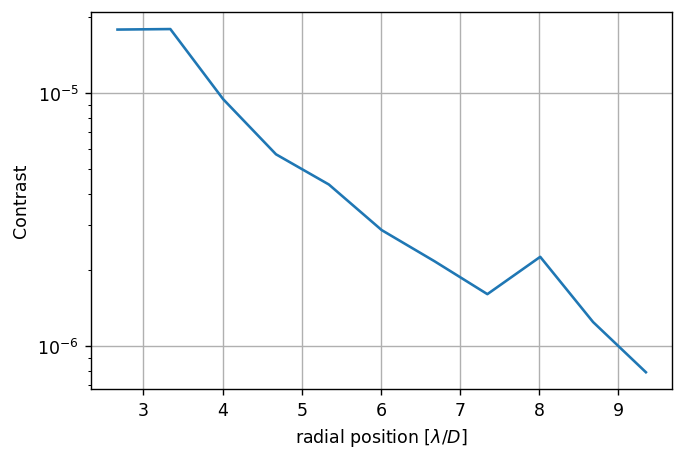

	Closed-loop iteration 14 / 20


(920,)

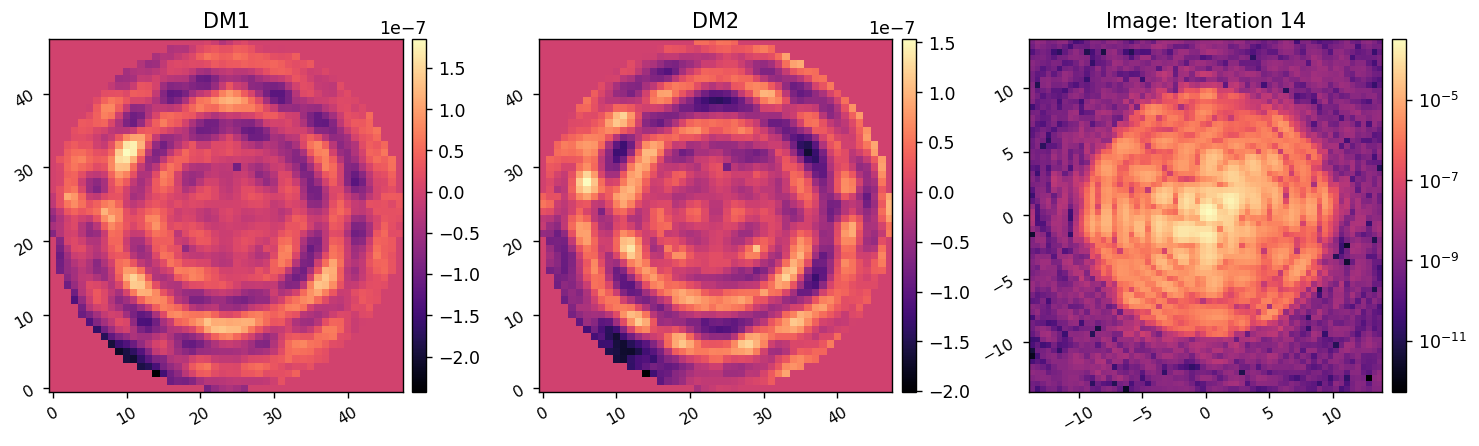

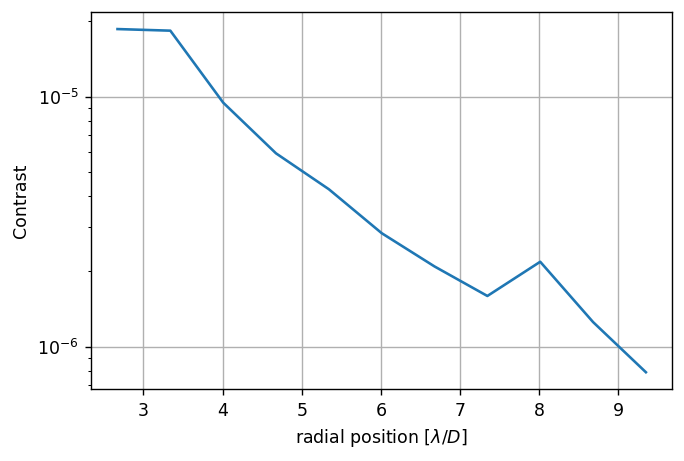

	Closed-loop iteration 15 / 20


(920,)

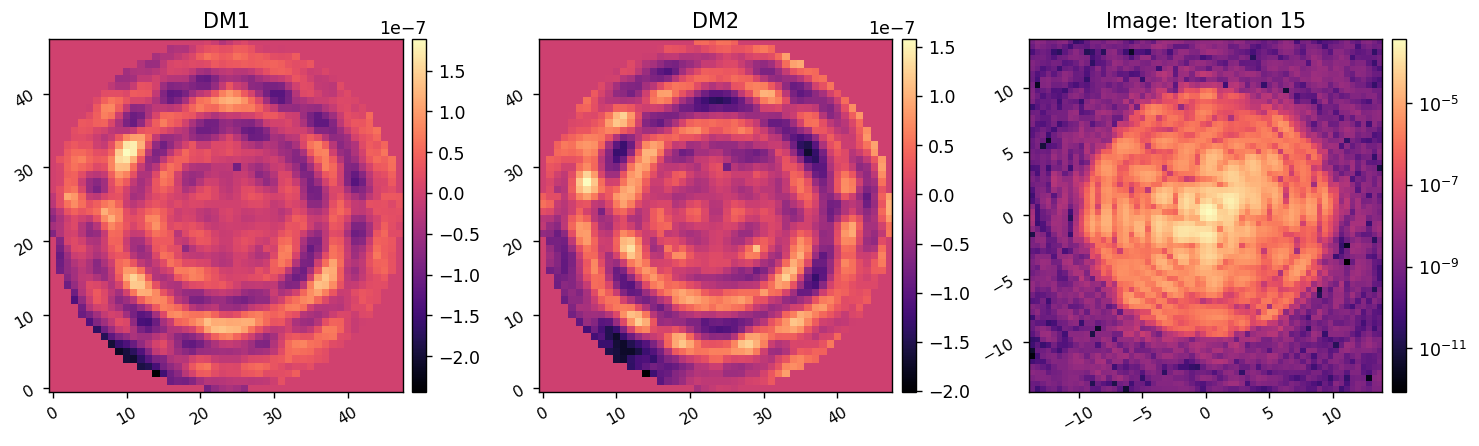

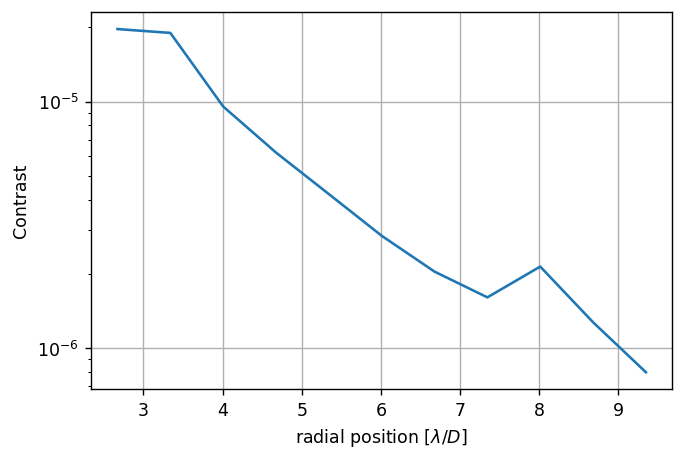

	Closed-loop iteration 16 / 20


(920,)

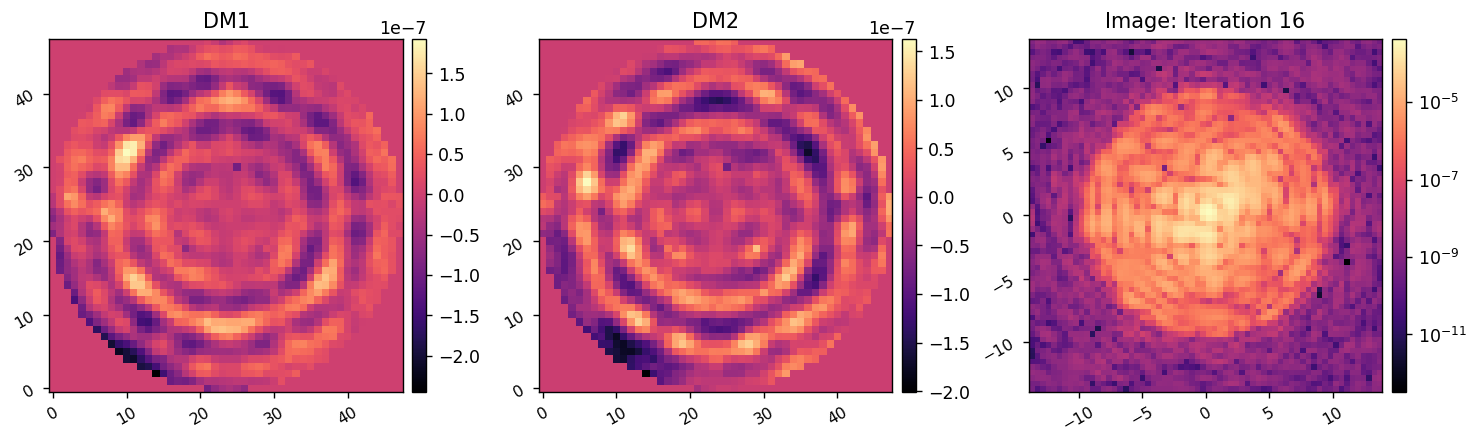

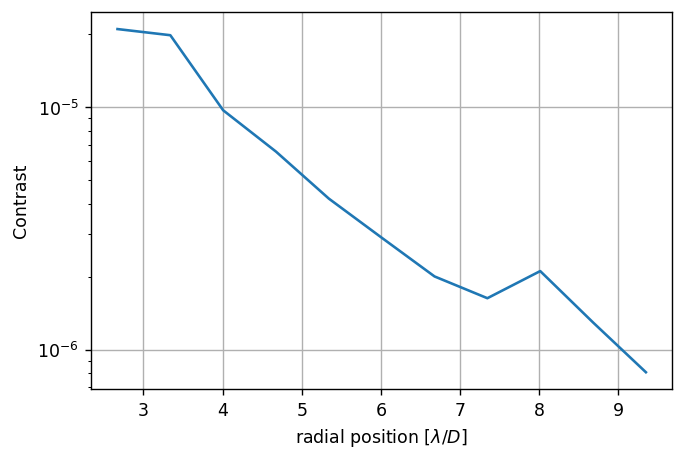

	Closed-loop iteration 17 / 20


(920,)

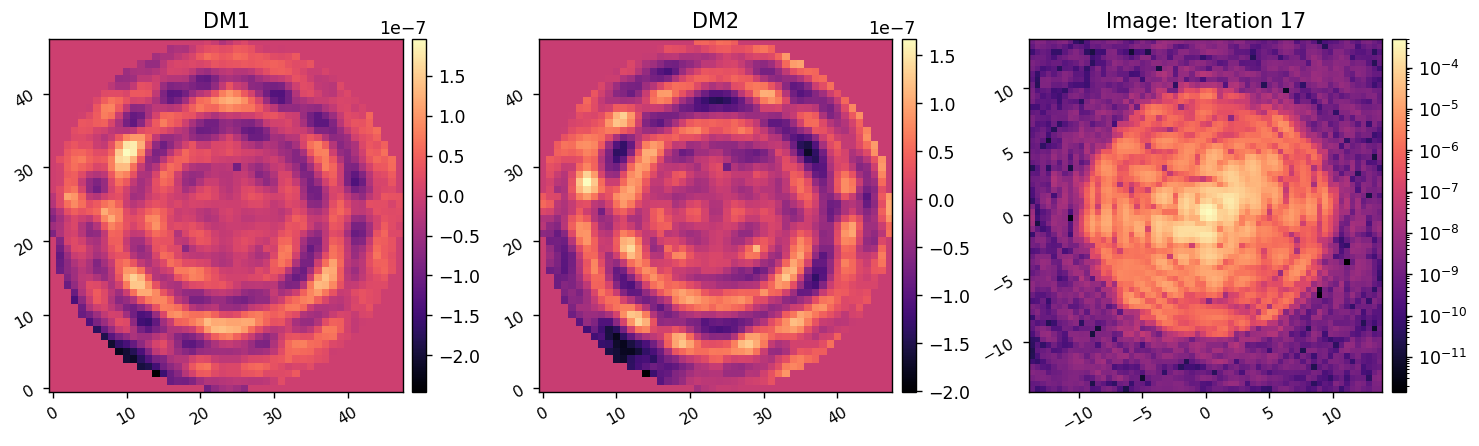

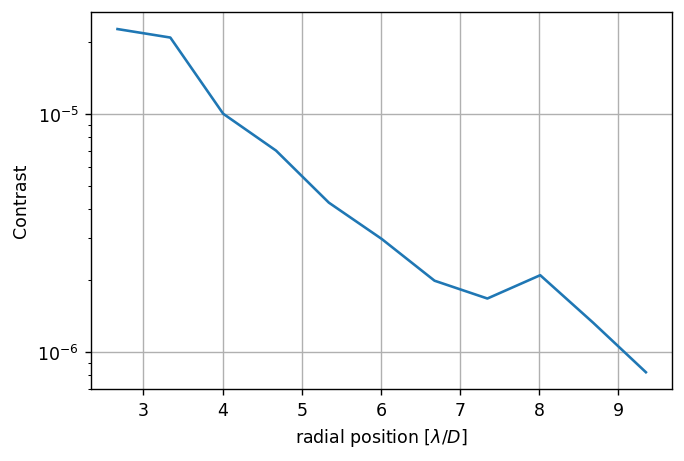

	Closed-loop iteration 18 / 20


(920,)

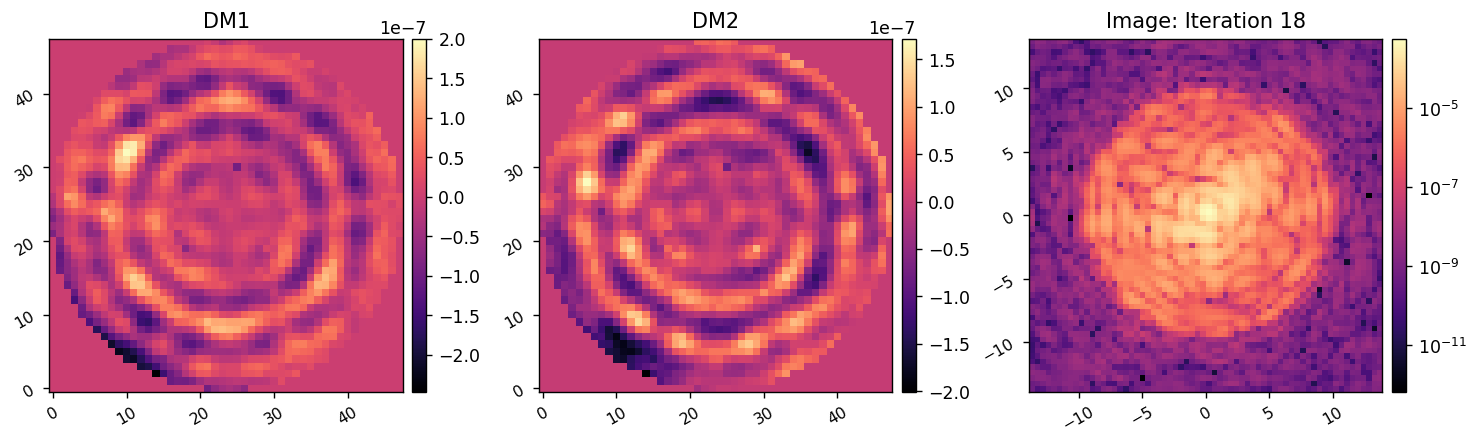

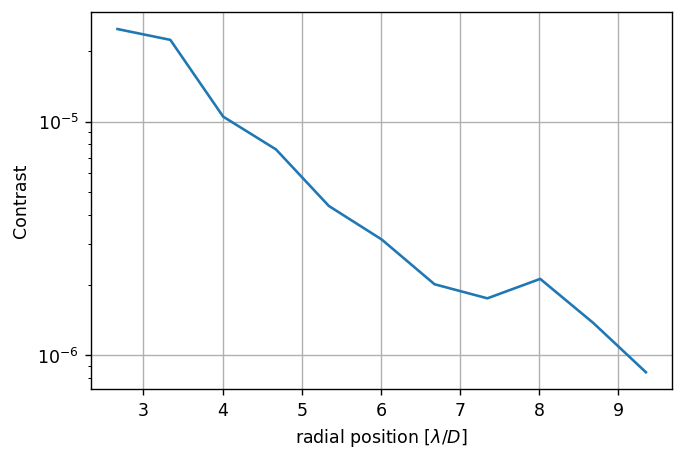

	Closed-loop iteration 19 / 20


(920,)

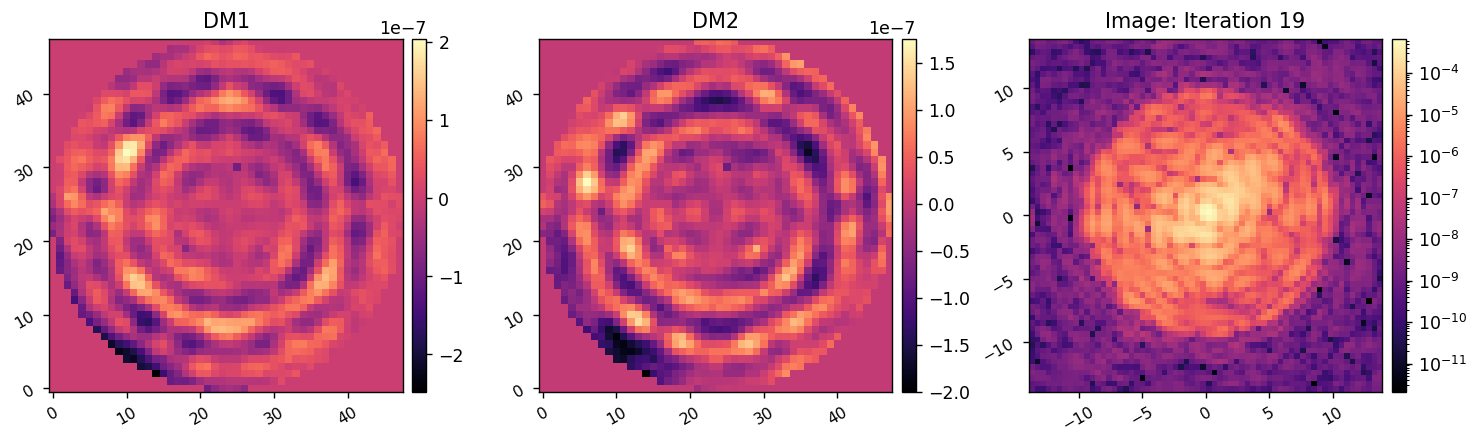

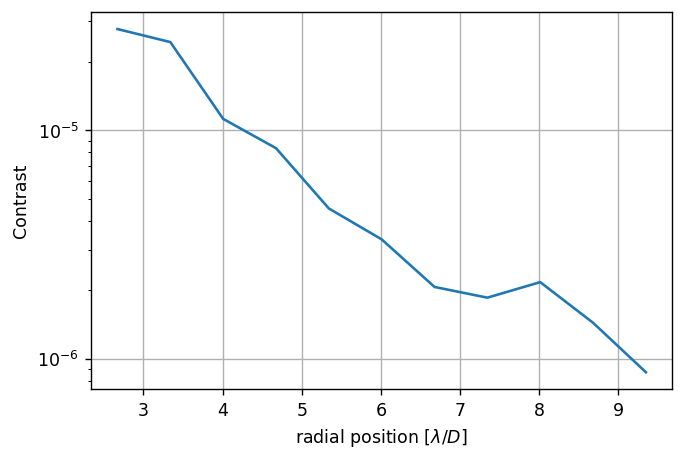

	Closed-loop iteration 20 / 20


(920,)

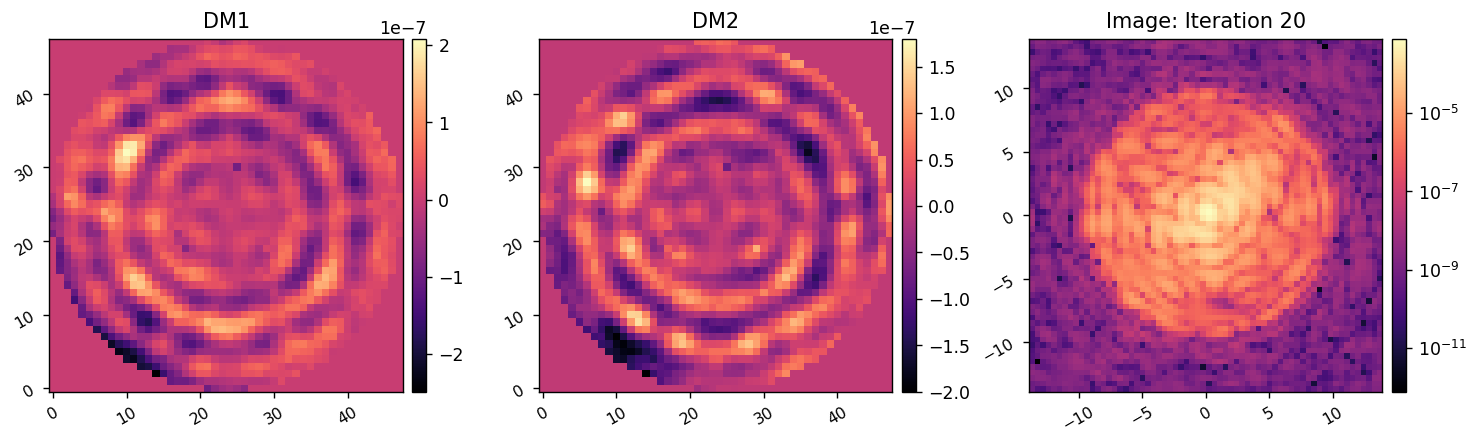

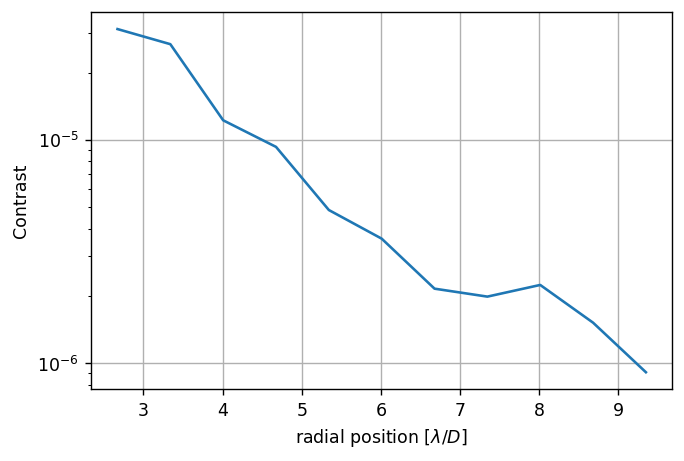

I-EFC loop completed in 47.098s.
Running I-EFC...
	Closed-loop iteration 1 / 20


(920,)

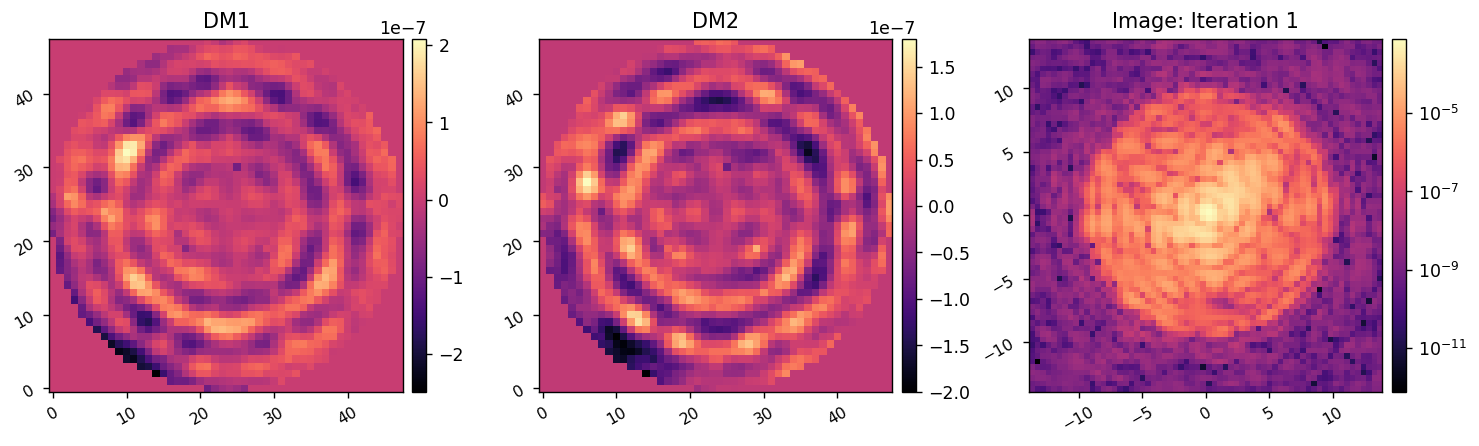

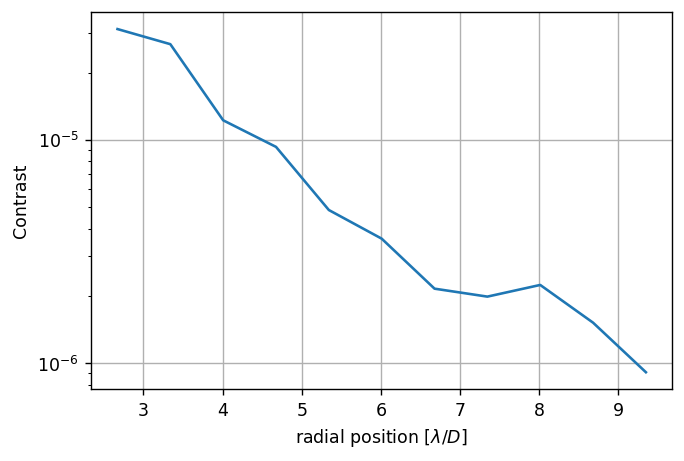

	Closed-loop iteration 2 / 20


(920,)

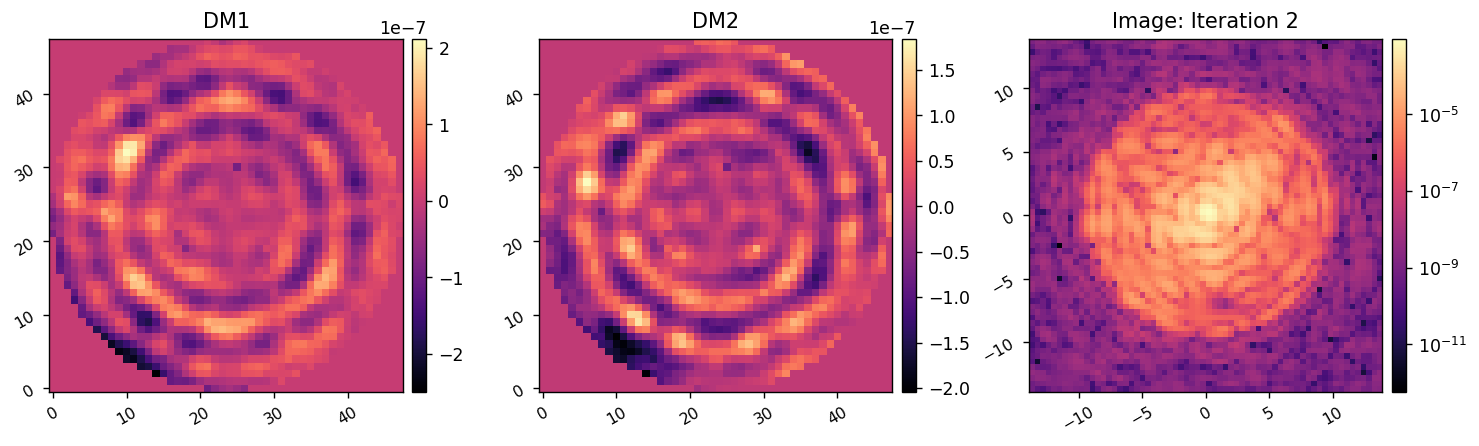

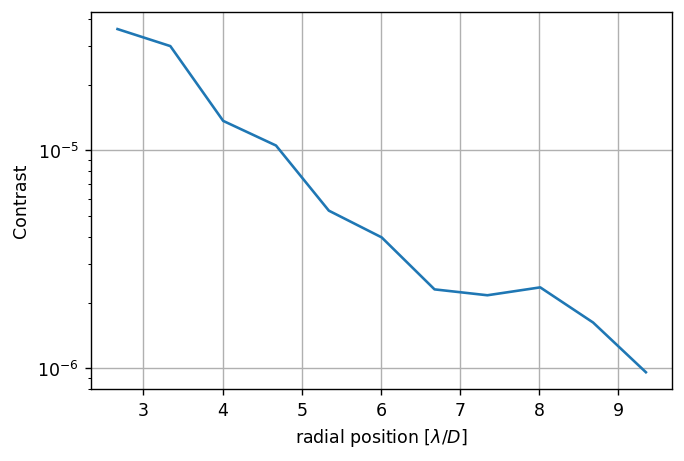

	Closed-loop iteration 3 / 20


(920,)

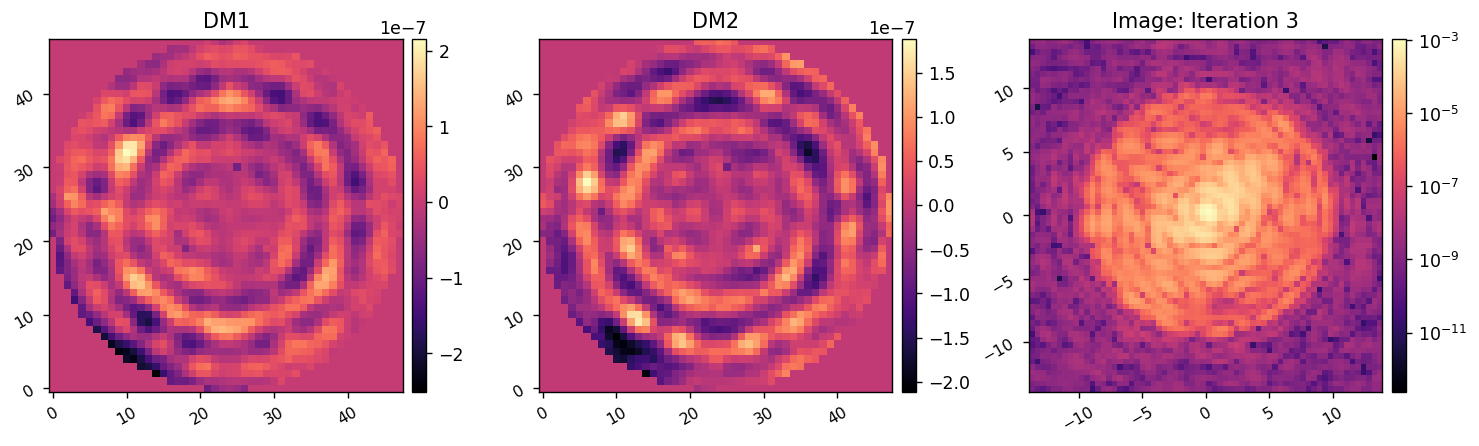

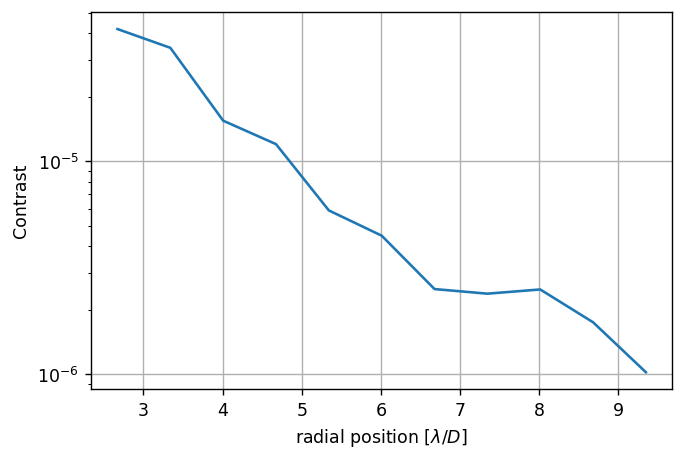

	Closed-loop iteration 4 / 20


In [ ]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-2
reg_conds = [(1e-2,10), (1e-2, 20), (1e-3, 20)]

cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

for i in range(len(reg_conds)):

    cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_conds[i][0])
    
    images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                              cm_tik,
                                              probe_modes, 
                                              probe_amp, 
                                              fourier_modes,
                                              control_mask, 
                                              num_iterations=reg_conds[i][1], 
                                              loop_gain=0.25, 
                                              leakage=0.0,
                                              plot_all=True,
                                             )